<a href="https://colab.research.google.com/github/EdFlo15/Anomaly_Detection_on_CoRE-Systems/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Records of Operations on the CoRE Systems


Source data:
https://data.mendeley.com/datasets/9k3pkspfxm/1

Description
The data is about the behaviors and activities of how participants use the CoRE system (http://core.cs.iastate.edu) and attack the system, such as clicking the buttons and links, filling out a form on the website, submitting request to the system server and searching information about the system.

There are two spreadsheets, data of the first-round experiment and data of the second-round experiment. In each spreadsheet, there are two sheets, "raw records" and "processed data". In the sheet of raw records, each row is a snapshot of user’s action and system context information when the user performed an operation on the CoRE system. Each raw record has the following information:

  (1) Time: the time point when the user performs an operation;

  (2) Login ID: user’s login ID provided by the CoRE system;

  (4) Action: including mouse click on a button or a link, and selection on a drop-down menu;

  (5) Page: the current webpage where the action occurs;

  (6) Next Page: the next page that the system will be directed to;

  (7) Content: contents on the webpage (user’s submitted input, system’s responses to the user’s action);

  (8) Goal: users' self-reported goal.

The processed data is processed from the raw records. Each row in the sheet of processed data has the follwoing information:
  (1) Observation: including user's action and content in the raw records;

  (2) Time Interval: the time interval between the time points of user's consecutive actions;
  
  (3) Goal: users' self-reported goal.

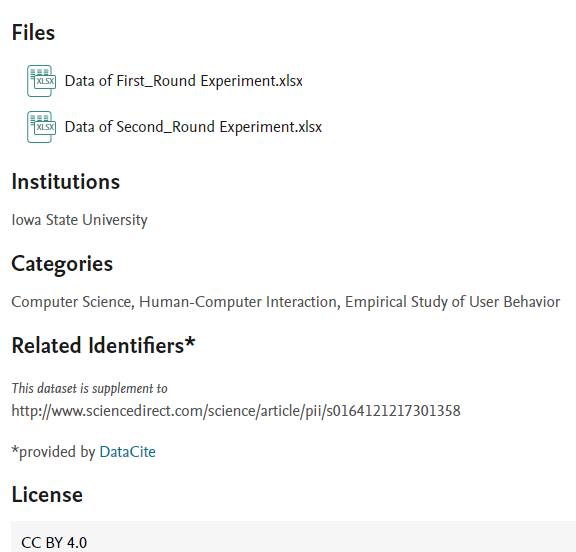

### Python version

In [1]:
# Version de python utilizada en el entorno
!python -V

Python 3.8.10


In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### librerias

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Funciones

In [4]:
def changeCharacternan(field):
  if field=="nan":
    return "21"
  else:
    return field

def transformTime(field):
  field=str(field).lstrip().rstrip()
  if(field=="h"):
    field='3600'
    return field
  elif(field=="m"):
    field='60'
    return field
  else:
    replace_field=field.replace('s','')
    replace_field=replace_field.lstrip().rstrip()
    return replace_field

def castToInt(field):
    field=changeCharacternan(transformTime(field))
    intValue=int(field.lstrip().rstrip())
    return intValue

def createLabel(field):
    if field=='Test':
      return 1
    else:
      return 0


## Data of first row experiment

Realizamos lectura de raw data directamente en la URL

In [5]:
import requests

url = 'https://data.mendeley.com/public-files/datasets/9k3pkspfxm/files/13fe969e-619e-4a03-98db-e63d126a2d0d/file_downloaded'
r = requests.get(url)
open('temp.xlsx', 'wb').write(r.content)
df_fist_round_raw = pd.read_excel('temp.xlsx',sheet_name="Raw Records")
df_fist_round_raw=df_fist_round_raw.iloc[:,0:7]
df_fist_round_raw

,Date,Login ID,Action,Page,Next Page,Content,Goal
0,2014-09-19 06:08:30,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test
1,2014-09-19 06:08:52,user136,click(Menuopt_AllPapers),Page_Home,Page_Login,NaN,Test
2,2014-09-19 06:09:19,user136,click(Btn_Login),Page_Login,Page_Home,[Login ID]KatsunoriOyama [Password]271adc [Mes...,Test
3,2014-09-19 06:09:34,user136,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,NaN,Test
4,2014-09-19 06:11:21,user136,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,[paper ID]1408576997,Test
...,...,...,...,...,...,...,...
7243,2014-10-08 11:46:32,user123,click(Link_PaperInfos),Page_MyComments,Page_MyComments,[paper ID]1412745509,View a Paper Info
7244,2014-10-08 11:46:45,user123,click(Link_PaperInfos),Page_MyComments,Page_MyComments,[paper ID]1412200664,View a Paper Info
7245,2014-10-08 11:47:58,user123,click(Menuopt_Home),Page_MyComments,Page_Home,NaN,Test
7246,2014-10-08 11:47:59,user123,click(Menuopt_Signout),Page_Home,Page_Login,NaN,Test


Lectura de Processed Data

In [6]:
df_fist_round_processed= pd.read_excel('temp.xlsx',sheet_name="Processed Data")
df_fist_round_processed=df_fist_round_processed.iloc[:,0:3]
df_fist_round_processed

,Observation,Time Interval,Goal
0,clickSkipPreQuestion,NaN,Test
1,clickMenuAllPapers,30s,ViewAllPapers
2,clickLogin&LoginGood,30s,ViewAllPapers
3,clickMenuAllPapers,20s,ViewAllPapers
4,clickPaperInfos&PaperID,m,ViewAPaperInfo
...,...,...,...
7243,clickPaperInfos&PaperID,10s,ViewMyCommentInfo
7244,clickPaperInfos&PaperID,20s,ViewMyCommentInfo
7245,clickMenuHome,m,Test
7246,clickMenuSignout,5s,Test


Las dos bases se unene para tener un dataset con 10 columnas

In [7]:
df_first_round_merge=pd.merge(df_fist_round_raw, df_fist_round_processed, left_index=True, right_index=True)
df_first_round_merge

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y
0,2014-09-19 06:08:30,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test,clickSkipPreQuestion,NaN,Test
1,2014-09-19 06:08:52,user136,click(Menuopt_AllPapers),Page_Home,Page_Login,NaN,Test,clickMenuAllPapers,30s,ViewAllPapers
2,2014-09-19 06:09:19,user136,click(Btn_Login),Page_Login,Page_Home,[Login ID]KatsunoriOyama [Password]271adc [Mes...,Test,clickLogin&LoginGood,30s,ViewAllPapers
3,2014-09-19 06:09:34,user136,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,NaN,Test,clickMenuAllPapers,20s,ViewAllPapers
4,2014-09-19 06:11:21,user136,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,[paper ID]1408576997,Test,clickPaperInfos&PaperID,m,ViewAPaperInfo
...,...,...,...,...,...,...,...,...,...,...
7243,2014-10-08 11:46:32,user123,click(Link_PaperInfos),Page_MyComments,Page_MyComments,[paper ID]1412745509,View a Paper Info,clickPaperInfos&PaperID,10s,ViewMyCommentInfo
7244,2014-10-08 11:46:45,user123,click(Link_PaperInfos),Page_MyComments,Page_MyComments,[paper ID]1412200664,View a Paper Info,clickPaperInfos&PaperID,20s,ViewMyCommentInfo
7245,2014-10-08 11:47:58,user123,click(Menuopt_Home),Page_MyComments,Page_Home,NaN,Test,clickMenuHome,m,Test
7246,2014-10-08 11:47:59,user123,click(Menuopt_Signout),Page_Home,Page_Login,NaN,Test,clickMenuSignout,5s,Test


In [8]:
# El nombre de las columnas se guarda para luego renombrar las columnas de "Data of second round experiment" debido a que algunas columnas no tienen el mismo nombre
column_names=list(df_first_round_merge.columns)

El primer registro de los datos se dió el 19 de septiembre de 2014 a las 6:08. El ultimo registro que se tiene es el 8 de octubre de 2014 a las 11:48. Son aproximadamente 18 días de recolección de información.

Todos los tipos de datos son categoricos nominales

In [9]:
df_first_round_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6880 non-null   datetime64[ns]
 1   Login ID       6880 non-null   object        
 2   Action         6880 non-null   object        
 3   Page           6880 non-null   object        
 4   Next Page      6880 non-null   object        
 5   Content        3862 non-null   object        
 6   Goal_x         6880 non-null   object        
 7   Observation    6880 non-null   object        
 8   Time Interval  6511 non-null   object        
 9   Goal_y         6880 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 566.4+ KB


La base de datos tiene información de 65 usuarios. Uno de los usuarios con Login ID user049 tiene 808 registros. Preliminarmente llama la atención por que podría tratarse de un usuario malintencionado o también puede ser un usuario que publica demasiados artículos.

### Eventos por usuario

In [10]:
df_users=pd.DataFrame(df_first_round_merge.value_counts('Login ID'))
df_users

,0
Login ID,
user049,808
user071,326
user112,277
user102,226
user029,226
...,...
user053,44
user143,42
user145,36


In [11]:
df_users.describe(percentiles=[0.05,0.25,0.5,0.75,0.80,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,80%,90%,99%,max
0,65.0,105.846154,104.172368,20.0,42.4,64.0,82.0,106.0,111.8,163.4,499.52,808.0


Analisis descriptivo del número de registros por usuario: Se observa que la mitad de los usuarios (mediana) tiene 82 registros (logs) el 80% tiene 111 logs. un 1% tiene 499 o más eventos. los cúales se pordrían revisar

Veamos la distribución gráficamente:

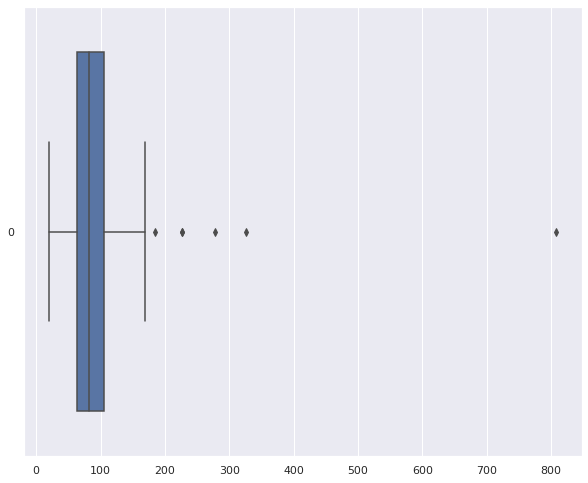

In [12]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.boxplot(data=df_users[0], orient="h",width=0.8)
plt.show()


En la distribución de logs por usuario se observan los átipicos. Corresponde a usuario que generan una cantidad de logs fuera de los rangos normales

### Analisis de la variable accion

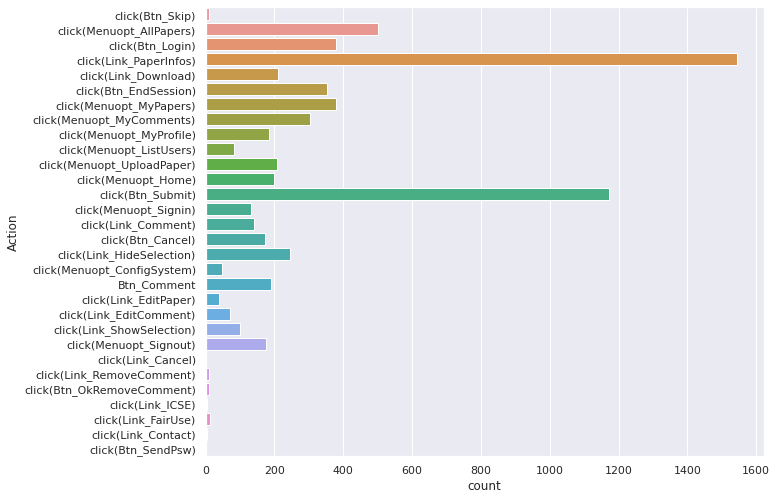

In [13]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_first_round_merge, y='Action')
plt.show()

In [14]:
df_first_round_merge['Action'].value_counts(normalize=True)*100

click(Link_PaperInfos)         22.441860
click(Btn_Submit)              17.049419
click(Menuopt_AllPapers)        7.281977
click(Menuopt_MyPapers)         5.508721
click(Btn_Login)                5.494186
click(Btn_EndSession)           5.145349
click(Menuopt_MyComments)       4.418605
click(Link_HideSelection)       3.546512
click(Link_Download)            3.037791
click(Menuopt_UploadPaper)      3.023256
click(Menuopt_Home)             2.906977
Btn_Comment                     2.747093
click(Menuopt_MyProfile)        2.688953
click(Menuopt_Signout)          2.558140
click(Btn_Cancel)               2.514535
click(Link_Comment)             2.063953
click(Menuopt_Signin)           1.918605
click(Link_ShowSelection)       1.453488
click(Menuopt_ListUsers)        1.220930
click(Link_EditComment)         1.017442
click(Menuopt_ConfigSystem)     0.697674
click(Link_EditPaper)           0.552326
click(Link_FairUse)             0.174419
click(Btn_OkRemoveComment)      0.130814
click(Btn_Skip) 

El 22.44% de los eventos son por click principalmente en el botón "Link_PaperInfos" y el 17% por "Btn_Submit" otra categoría con menor porcentaje es "Menuopt_AllPapers" con un 7.2%.

De acuerdo a esta información podría inferirse que se trata de un portal que permíte publicar Papers a los usuarios quienes los envían o cargan cuando hacen click en el botón "btn_Submit".

Los atacantes o usuarios malintenconados generalente buscan campos en donde se pueda cargar información tales como campos de envio de comentarios o cargas de archivos (estos son los más peligrosos) debido a que usuarios malintencionados intentan ejecutar XSS, inyección SQL o cargar un payload que luego ejecutan para vulnerar el sistema

### Analisi de la variable Page

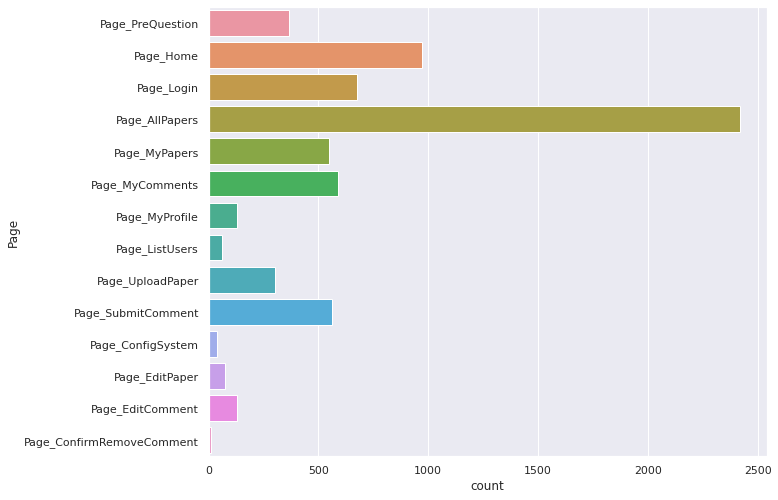

In [15]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_first_round_merge, y='Page')
plt.show()

In [16]:
df_first_round_merge['Page'].value_counts(normalize=True)*100

Page_AllPapers               35.159884
Page_Home                    14.142442
Page_Login                    9.811047
Page_MyComments               8.546512
Page_SubmitComment            8.168605
Page_MyPapers                 7.965116
Page_PreQuestion              5.334302
Page_UploadPaper              4.375000
Page_MyProfile                1.904070
Page_EditComment              1.860465
Page_EditPaper                1.104651
Page_ListUsers                0.915698
Page_ConfigSystem             0.581395
Page_ConfirmRemoveComment     0.130814
Name: Page, dtype: float64

El 35% de los eventos ocurre en "Page_AllPapers".  El 14.14% en "Home page". El 9.8% en "Login" y 8.5 % en "Page_MyComments". Es importante también prestar atención a "Page_SubmitComment". 

De acuerdo con esta información el portal permite visualizar los papers y recibir información de comentarios de sus usuarios, editar comentarios. Además se observa que el portal permite cargar papers.

### Analisis de la variable Next Page

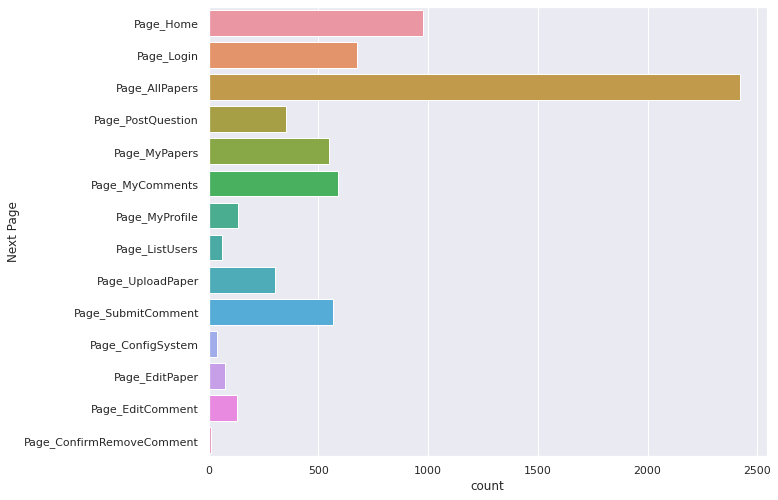

In [17]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_first_round_merge, y='Next Page')
plt.show()

In [18]:
df_first_round_merge['Next Page'].value_counts(normalize=True)*100

Page_AllPapers               35.188953
Page_Home                    14.186047
Page_Login                    9.811047
Page_MyComments               8.546512
Page_SubmitComment            8.226744
Page_MyPapers                 7.979651
Page_PostQuestion             5.145349
Page_UploadPaper              4.389535
Page_MyProfile                1.933140
Page_EditComment              1.860465
Page_EditPaper                1.104651
Page_ListUsers                0.915698
Page_ConfigSystem             0.581395
Page_ConfirmRemoveComment     0.130814
Name: Next Page, dtype: float64

El 35% de los eventos ocurre en "Page_AllPapers". El 14.18% en Page Home. El 9.8 en Page Login.

De acuerdo con la información los usuarios permanecen principalmente en la página "Page_AllPapers".

### Analisis de la variable Goal_x

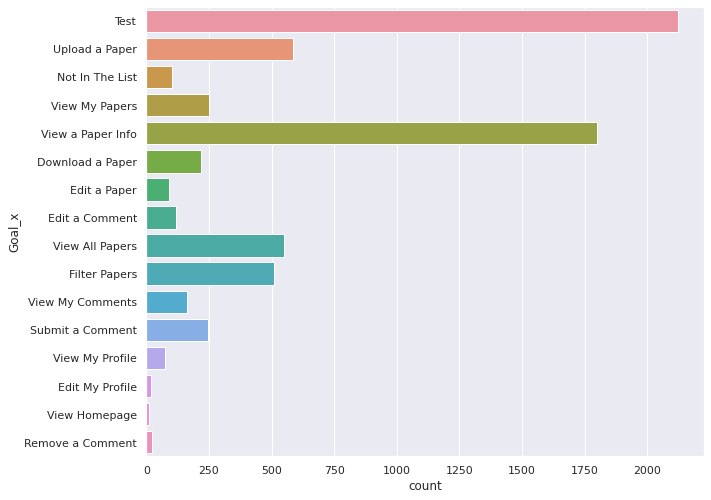

In [19]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_first_round_merge, y='Goal_x')
plt.show()

In [20]:
df_first_round_merge['Goal_x'].value_counts(normalize=True)*100

Test                 30.857558
View a Paper Info    26.162791
Upload a Paper        8.502907
View All Papers       7.994186
Filter Papers         7.412791
View My Papers        3.604651
Submit a Comment      3.590116
Download a Paper      3.168605
View My Comments      2.369186
Edit a Comment        1.744186
Not In The List       1.468023
Edit a Paper          1.293605
View My Profile       1.090116
Remove a Comment      0.305233
Edit My Profile       0.261628
View Homepage         0.174419
Name: Goal_x, dtype: float64

El 30.85% de los eventos corresponde a la categoría Test. El 26.16% a la categoría View a Paper Info.

Preliminarmente podría pensarse en la variable Test como una especie de prueba.

### Analisis de la variable Goal_y

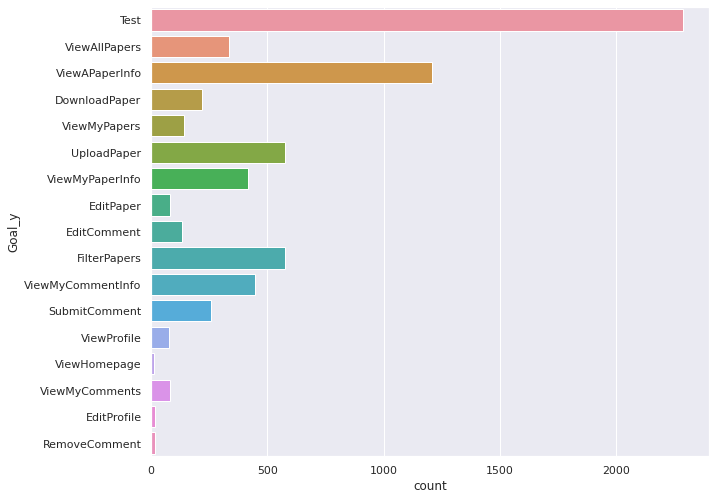

In [21]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_first_round_merge, y='Goal_y')
plt.show()

In [22]:
df_first_round_merge['Goal_y'].value_counts(normalize=True)*100

Test                 33.226744
ViewAPaperInfo       17.558140
FilterPapers          8.372093
UploadPaper           8.343023
ViewMyCommentInfo     6.482558
ViewMyPaperInfo       6.031977
ViewAllPapers         4.883721
SubmitComment         3.764535
DownloadPaper         3.183140
ViewMyPapers          2.078488
EditComment           1.904070
ViewMyComments        1.206395
EditPaper             1.191860
ViewProfile           1.104651
RemoveComment         0.261628
EditProfile           0.247093
ViewHomepage          0.159884
Name: Goal_y, dtype: float64

El 33.22% de los eventos son de Test. El 17.55% son de ViewAPaperInfo





Existe un usuario que llama especialente la atención por generar 808 eventos y es el usuario user049. Podría tratarse de un usuario malintencionado, un administrador o el encargado de revision de los papers.

Observemos los eventos para este usuario

In [23]:
df_fist_round_raw[df_fist_round_raw['Login ID']=='user049']

,Date,Login ID,Action,Page,Next Page,Content,Goal
5248,2014-09-16 17:34:07,user049,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:\n[Familiar] D,Test
5249,2014-09-16 17:34:13,user049,click(Menuopt_UploadPaper),Page_Home,Page_Login,NaN,Not In The List
5250,2014-09-16 17:34:25,user049,click(Btn_Login),Page_Login,Page_UploadPaper,[Login ID]user049 [Password]4fa974 [Message]Lo...,Not In The List
5251,2014-09-16 17:39:47,user049,Btn_Comment,Page_UploadPaper,Page_SubmitComment,[FORM_Title] Seeking Quality through User-Goal...,Upload a Paper
5252,2014-09-16 17:41:08,user049,click(Btn_Submit),Page_SubmitComment,Page_SubmitComment,[paper ID] NULL\n[FORM_Overall] 5\n[FORM_Categ...,Upload a Paper
...,...,...,...,...,...,...,...
6076,2014-10-21 17:25:50,user049,click(Link_HideSelection),Page_AllPapers,Page_AllPapers,NaN,View All Papers
6077,2014-10-21 17:26:01,user049,click(Link_ShowSelection),Page_AllPapers,Page_AllPapers,NaN,Test
6078,2014-10-21 17:26:04,user049,click(Menuopt_Signout),Page_AllPapers,Page_Login,NaN,Test
6079,2014-10-21 17:26:06,user049,click(Menuopt_Home),Page_Login,Page_Home,NaN,Test


In [24]:
df_fist_round_raw[df_fist_round_raw['Login ID']=='user049']['Goal'].value_counts()

View a Paper Info    431
Test                  82
View All Papers       74
Filter Papers         70
View My Papers        39
Upload a Paper        21
Edit a Comment        20
Edit a Paper          17
Download a Paper      16
View My Comments      14
Edit My Profile        8
Submit a Comment       8
View My Profile        6
Not In The List        2
Name: Goal, dtype: int64

De acuerdo al objetivo reportado este usuario user049 parece ser un revisor de papers. Igualmente en los eventos no se observa tráfico malicioso, pero si eventos de edición de papers, edición de comentarios y publicaciones por lo que se puede pensar como un operador encargado de las publicaciones.

In [25]:
df_fist_round_raw[df_fist_round_raw['Login ID']=='user071']['Goal'].value_counts()

View a Paper Info    88
Test                 58
View All Papers      37
View My Comments     24
Filter Papers        20
Remove a Comment     17
Upload a Paper       16
View My Papers       15
Download a Paper     13
Not In The List      13
Submit a Comment     10
Edit a Comment       10
View My Profile       3
Edit a Paper          2
Name: Goal, dtype: int64

De igual manera el usuario user071 presenta varios eventos en la categoría View a Paper Info 

In [26]:
df_fist_round_raw[df_fist_round_raw['Login ID']=='user112']['Goal'].value_counts()

View a Paper Info    112
Test                  64
Filter Papers         32
Download a Paper      22
Upload a Paper        14
View All Papers       12
Submit a Comment       8
View My Profile        6
View My Comments       4
View My Papers         3
Name: Goal, dtype: int64

In [27]:
df_fist_round_raw[df_fist_round_raw['Login ID']=='user112']

,Date,Login ID,Action,Page,Next Page,Content,Goal
2482,2014-09-29 15:11:27,user112,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:\n[Familiar] B,Test
2483,2014-09-29 15:12:00,user112,click(Menuopt_Signin),Page_Home,Page_Login,NaN,Test
2484,2014-09-29 15:12:13,user112,click(Btn_Login),Page_Login,Page_Home,[Login ID]user112 [Password]d2297d [Message]Lo...,Test
2485,2014-09-29 15:12:26,user112,click(Menuopt_UploadPaper),Page_Home,Page_UploadPaper,NaN,Test
2486,2014-09-29 15:12:46,user112,click(Btn_Cancel),Page_UploadPaper,Page_Home,NaN,Test
...,...,...,...,...,...,...,...
2760,2014-10-08 18:04:40,user112,click(Link_HideSelection),Page_AllPapers,Page_AllPapers,NaN,View All Papers
2761,2014-10-08 18:04:47,user112,click(Menuopt_MyProfile),Page_AllPapers,Page_MyProfile,NaN,Test
2762,2014-10-08 18:04:48,user112,click(Menuopt_Signout),Page_MyProfile,Page_Login,NaN,Test
2763,2014-10-08 18:04:48,user112,click(Menuopt_Home),Page_Login,Page_Home,NaN,Test


De igual manera, no se encontraron eventos que hicieran pensar de que se trataba de un usuario malicioso

## Data of second round experiment

Lectura de raw record 

In [28]:
url = 'https://data.mendeley.com/public-files/datasets/9k3pkspfxm/files/9286bf12-acb6-482e-a239-c3a00130be92/file_downloaded'
r = requests.get(url)
open('temp.xlsx', 'wb').write(r.content)
df_second_round_raw= pd.read_excel('temp.xlsx',sheet_name="Raw Records")
df_second_round_raw

,Time,UserID,Action,Page,NextPage,Content,Goal
0,2014-12-14 14:36:04,user012,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:#3#\n[Famili...,NaN
1,2014-12-14 14:36:13,user012,click(Menuopt_MyPapers),Page_Home,Page_Login,NaN,View My Papers
2,2014-12-14 14:36:22,user012,click(Btn_Login),Page_Login,Page_Home,[Login ID]user012 [Password]a0b1d8 [Message]Lo...,View My Papers
3,2014-12-14 14:36:24,user012,click(Menuopt_MyPapers),Page_Home,Page_MyPapers,NaN,View My Papers
4,2014-12-14 14:36:29,user012,click(Menuopt_MyComments),Page_MyPapers,Page_MyComments,NaN,View My Comments
...,...,...,...,...,...,...,...
7186,2015-01-09 05:40:35,user083,click(Link_Comment),Page_MyPapers,Page_SubmitComment,[paper ID]1420802620,View My Comments
7187,2015-01-09 05:41:37,user083,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,NaN,View My Comments
7188,2015-01-09 05:41:49,user083,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,NaN,Not In The List
7189,2015-01-09 05:41:53,user083,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,[paper ID]1420802620,Not In The List


Lectura de Processed Data

In [29]:
df_second_round_processed= pd.read_excel('temp.xlsx',sheet_name="Processed Data")
df_second_round_processed=df_second_round_processed.iloc[:,0:3]
df_second_round_processed

,Observation,Time Interval,Goal
0,clickSubmitPreQuestion&PreAnswer,NaN,Test
1,clickMenuMyPapers,10s,ViewMyPapers
2,clickLogin&LoginGood,10s,ViewMyPapers
3,clickMenuMyPapers,5s,ViewMyPapers
4,clickMenuMyComments,10s,ViewMyComments
...,...,...,...
7186,clickSubmitCommentMyPapers&PaperID,20s,SubmitComment
7187,clickMenuAllPapers,m,ViewAllPapers
7188,clickMenuMyPapers,20s,ViewMyPapers
7189,clickEditPaperMyPapers&PaperID,5s,Test


Se realiza merge de los dos datasets para tener un base de 7191 filas con 10 columnas

In [30]:
df_second_round_merge=pd.merge(df_second_round_raw, df_second_round_processed, left_index=True, right_index=True)
df_second_round_merge

,Time,UserID,Action,Page,NextPage,Content,Goal_x,Observation,Time Interval,Goal_y
0,2014-12-14 14:36:04,user012,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:#3#\n[Famili...,NaN,clickSubmitPreQuestion&PreAnswer,NaN,Test
1,2014-12-14 14:36:13,user012,click(Menuopt_MyPapers),Page_Home,Page_Login,NaN,View My Papers,clickMenuMyPapers,10s,ViewMyPapers
2,2014-12-14 14:36:22,user012,click(Btn_Login),Page_Login,Page_Home,[Login ID]user012 [Password]a0b1d8 [Message]Lo...,View My Papers,clickLogin&LoginGood,10s,ViewMyPapers
3,2014-12-14 14:36:24,user012,click(Menuopt_MyPapers),Page_Home,Page_MyPapers,NaN,View My Papers,clickMenuMyPapers,5s,ViewMyPapers
4,2014-12-14 14:36:29,user012,click(Menuopt_MyComments),Page_MyPapers,Page_MyComments,NaN,View My Comments,clickMenuMyComments,10s,ViewMyComments
...,...,...,...,...,...,...,...,...,...,...
7186,2015-01-09 05:40:35,user083,click(Link_Comment),Page_MyPapers,Page_SubmitComment,[paper ID]1420802620,View My Comments,clickSubmitCommentMyPapers&PaperID,20s,SubmitComment
7187,2015-01-09 05:41:37,user083,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,NaN,View My Comments,clickMenuAllPapers,m,ViewAllPapers
7188,2015-01-09 05:41:49,user083,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,NaN,Not In The List,clickMenuMyPapers,20s,ViewMyPapers
7189,2015-01-09 05:41:53,user083,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,[paper ID]1420802620,Not In The List,clickEditPaperMyPapers&PaperID,5s,Test


El primer registro de los datos se dió el 14 de diciembre de 2014 a las 14:36. El ultimo registro que se tiene es el 09 de Enero de 2015 a las 5:42. Son aproximadamente 26 días de recolección de información.

### Eventos por usuarios

In [31]:
df_users_second_round=pd.DataFrame(df_second_round_merge.value_counts('UserID'))
df_users_second_round

,0
UserID,
user049,822
user051,214
user260,200
user143,176
user059,173
...,...
user029,14
user131,12
user018,11


En la base "Data of second round experiment" se observa nuevamente el user049 con más eventos generados (822)

In [32]:
df_users_second_round.describe(percentiles=[0.05,0.25,0.5,0.75,0.80,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,80%,90%,99%,max
0,66.0,105.015152,103.823444,9.0,12.5,52.0,87.5,138.0,155.0,168.5,426.8,822.0


En promedio por usuario se generan 105 eventos. La mitad de ellos genera 87 eventos aproximadamente (mediana)

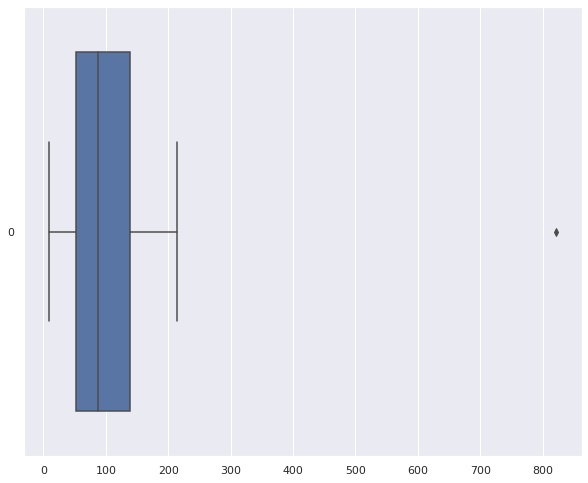

In [33]:
sns.boxplot(data=df_users_second_round[0], orient="h",width=0.8)
plt.show()


### Analisis de la variable accion

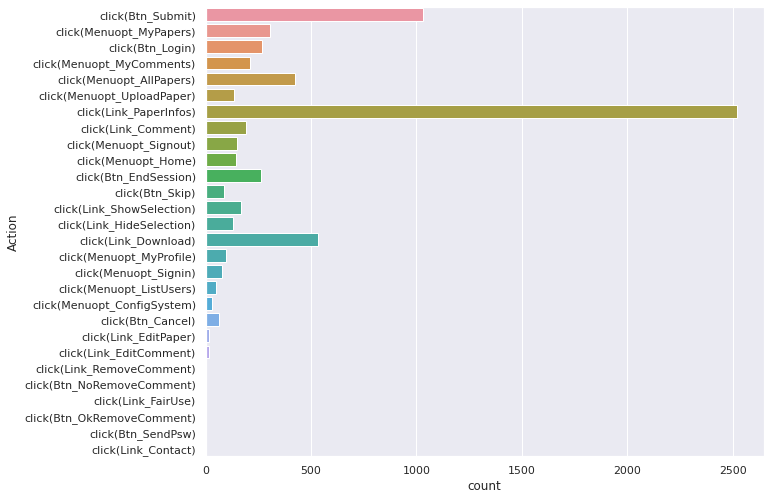

In [34]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_second_round_merge, y='Action')
plt.show()

### Analisis de la variable page

In [35]:
df_second_round_merge['Action'].value_counts(normalize=True)*100

click(Link_PaperInfos)         36.358390
click(Btn_Submit)              14.875198
click(Link_Download)            7.675660
click(Menuopt_AllPapers)        6.146299
click(Menuopt_MyPapers)         4.414947
click(Btn_Login)                3.837830
click(Btn_EndSession)           3.765690
click(Menuopt_MyComments)       3.073150
click(Link_Comment)             2.770163
click(Link_ShowSelection)       2.452749
click(Menuopt_Signout)          2.178618
click(Menuopt_Home)             2.092050
click(Menuopt_UploadPaper)      1.918915
click(Link_HideSelection)       1.890059
click(Menuopt_MyProfile)        1.428365
click(Btn_Skip)                 1.226374
click(Menuopt_Signin)           1.154235
click(Btn_Cancel)               0.908960
click(Menuopt_ListUsers)        0.735825
click(Menuopt_ConfigSystem)     0.447266
click(Link_EditComment)         0.259703
click(Link_EditPaper)           0.201991
click(Link_RemoveComment)       0.057712
click(Link_FairUse)             0.043284
click(Btn_NoRemo

El 36.35% de los eventos son por click principalmente en el botón "Link_PaperInfos" y el 14.87% por "Btn_Submit" otra categoría con menor porcentaje es "Link_Download" con un 7.6%.

De acuerdo a esta información podría inferirse que se trata de un portal que permíte publicar Papers a los usuarios quienes los envían o cargan cuando hacen click en el botón "btn_Submit". Adicinalmente se permite la descarga de los papers.

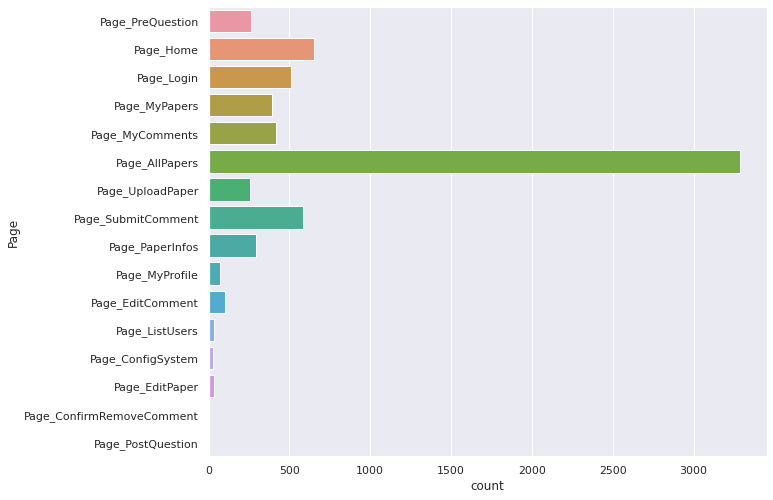

In [36]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_second_round_merge, y='Page')
plt.show()

In [37]:
df_second_round_merge['Page'].value_counts(normalize=True)*100

Page_AllPapers               47.424614
Page_Home                     9.421440
Page_SubmitComment            8.469196
Page_Login                    7.343818
Page_MyComments               5.973164
Page_MyPapers                 5.655750
Page_PaperInfos               4.270668
Page_PreQuestion              3.765690
Page_UploadPaper              3.736835
Page_EditComment              1.457221
Page_MyProfile                1.053239
Page_ListUsers                0.490550
Page_EditPaper                0.490550
Page_ConfigSystem             0.375126
Page_ConfirmRemoveComment     0.057712
Page_PostQuestion             0.014428
Name: Page, dtype: float64

El 47.42% de los eventos ocurre en "Page_AllPapers".  El 9.42% en "Home page". El 8.46 en Page_SubmitComment.

De acuerdo con esta información el portal permite visualizar los papers y recibir información de comentarios de sus usuarios, editar comentarios, etc. Además se observa que el portal permite cargar papers.

### Analisis de la variable Next Page

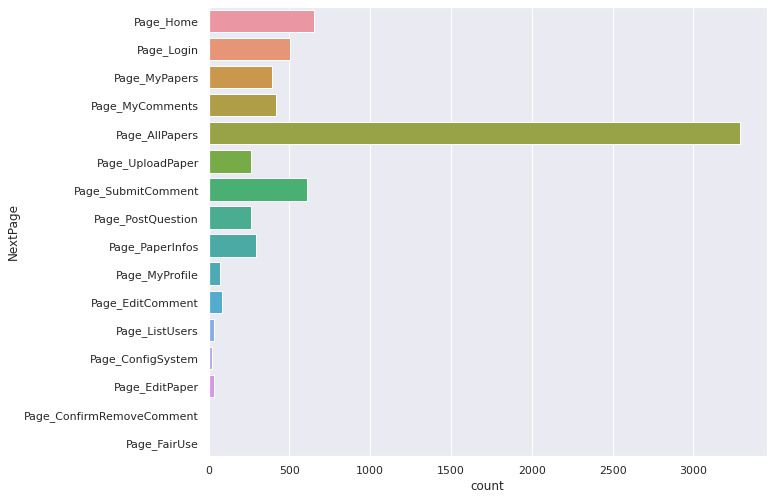

In [38]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_second_round_merge, y='NextPage')
plt.show()

In [39]:
df_second_round_merge['NextPage'].value_counts(normalize=True)*100

Page_AllPapers               47.439042
Page_Home                     9.407012
Page_SubmitComment            8.815467
Page_Login                    7.286106
Page_MyComments               5.987592
Page_MyPapers                 5.626894
Page_PaperInfos               4.241812
Page_UploadPaper              3.765690
Page_PostQuestion             3.765690
Page_EditComment              1.183090
Page_MyProfile                1.038811
Page_EditPaper                0.504978
Page_ListUsers                0.490550
Page_ConfigSystem             0.346270
Page_ConfirmRemoveComment     0.057712
Page_FairUse                  0.043284
Name: NextPage, dtype: float64

El 47.43% de los eventos ocurre en "Page_AllPapers". El 9.40% en Page Home. El 8.8 Page_SubmitComment.

De acuerdo con la información los usuarios permanecen principalmente en la página "Page_AllPapers".

### Analisis de la variable Goal x

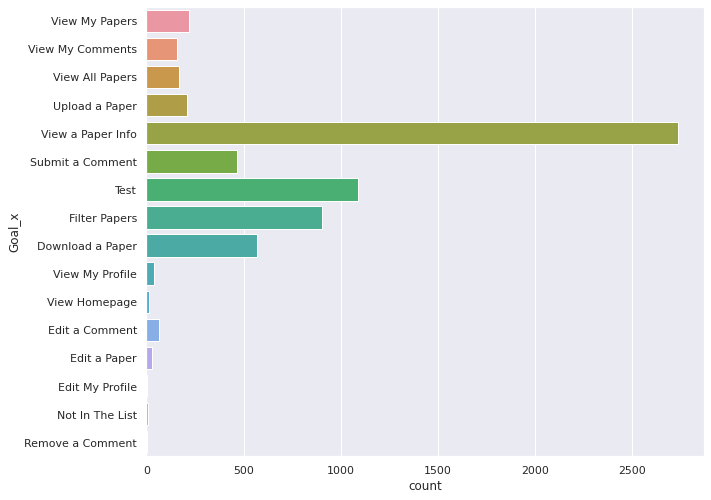

In [40]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_second_round_merge, y='Goal_x')
plt.show()

In [41]:
df_second_round_merge['Goal_x'].value_counts(normalize=True)*100

View a Paper Info    41.010646
Test                 16.299295
Filter Papers        13.525266
Download a Paper      8.532014
Submit a Comment      7.017544
View My Papers        3.253861
Upload a Paper        3.118908
View All Papers       2.489129
View My Comments      2.369171
Edit a Comment        0.959664
View My Profile       0.584795
Edit a Paper          0.449843
View Homepage         0.194932
Not In The List       0.119958
Edit My Profile       0.044984
Remove a Comment      0.029990
Name: Goal_x, dtype: float64

El 41.01% de los eventos corresponde a la categoría "View a Paper Info". El 16.29% a la categoría Test.

Preliminarmente podría pensarse en la variable Test como una especie de prueba.

### Analisis de la variable goal y

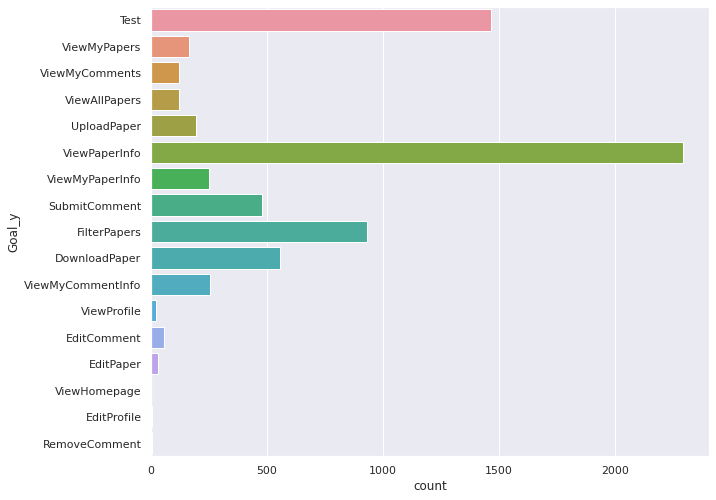

In [42]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df_second_round_merge, y='Goal_y')
plt.show()

In [43]:
df_second_round_merge['Goal_y'].value_counts(normalize=True)*100

ViewPaperInfo        33.068821
Test                 21.122493
FilterPapers         13.432405
DownloadPaper         7.993075
SubmitComment         6.896552
ViewMyCommentInfo     3.693551
ViewMyPaperInfo       3.592555
UploadPaper           2.770163
ViewMyPapers          2.351753
ViewAllPapers         1.745780
ViewMyComments        1.716924
EditComment           0.779108
EditPaper             0.403982
ViewProfile           0.302987
RemoveComment         0.072140
EditProfile           0.043284
ViewHomepage          0.014428
Name: Goal_y, dtype: float64

El 33.06% de los eventos son de ViewAPaperInfo. El 21.12% son de Test

Renombramiento de las columnas para unificar todo el dataset posteriormente

In [44]:
df_second_round_merge.columns=column_names
df_second_round_merge

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y
0,2014-12-14 14:36:04,user012,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:#3#\n[Famili...,NaN,clickSubmitPreQuestion&PreAnswer,NaN,Test
1,2014-12-14 14:36:13,user012,click(Menuopt_MyPapers),Page_Home,Page_Login,NaN,View My Papers,clickMenuMyPapers,10s,ViewMyPapers
2,2014-12-14 14:36:22,user012,click(Btn_Login),Page_Login,Page_Home,[Login ID]user012 [Password]a0b1d8 [Message]Lo...,View My Papers,clickLogin&LoginGood,10s,ViewMyPapers
3,2014-12-14 14:36:24,user012,click(Menuopt_MyPapers),Page_Home,Page_MyPapers,NaN,View My Papers,clickMenuMyPapers,5s,ViewMyPapers
4,2014-12-14 14:36:29,user012,click(Menuopt_MyComments),Page_MyPapers,Page_MyComments,NaN,View My Comments,clickMenuMyComments,10s,ViewMyComments
...,...,...,...,...,...,...,...,...,...,...
7186,2015-01-09 05:40:35,user083,click(Link_Comment),Page_MyPapers,Page_SubmitComment,[paper ID]1420802620,View My Comments,clickSubmitCommentMyPapers&PaperID,20s,SubmitComment
7187,2015-01-09 05:41:37,user083,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,NaN,View My Comments,clickMenuAllPapers,m,ViewAllPapers
7188,2015-01-09 05:41:49,user083,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,NaN,Not In The List,clickMenuMyPapers,20s,ViewMyPapers
7189,2015-01-09 05:41:53,user083,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,[paper ID]1420802620,Not In The List,clickEditPaperMyPapers&PaperID,5s,Test


## EDA para todo el dataset

Apartir de aqui se realiza el analisis para toda la base unida. Esto se logra realizando la concatenación de las doas bases.

In [45]:
df_total=pd.concat([df_first_round_merge,df_second_round_merge],axis=0,ignore_index=True)
df_total

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y
0,2014-09-19 06:08:30,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test,clickSkipPreQuestion,NaN,Test
1,2014-09-19 06:08:52,user136,click(Menuopt_AllPapers),Page_Home,Page_Login,NaN,Test,clickMenuAllPapers,30s,ViewAllPapers
2,2014-09-19 06:09:19,user136,click(Btn_Login),Page_Login,Page_Home,[Login ID]KatsunoriOyama [Password]271adc [Mes...,Test,clickLogin&LoginGood,30s,ViewAllPapers
3,2014-09-19 06:09:34,user136,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,NaN,Test,clickMenuAllPapers,20s,ViewAllPapers
4,2014-09-19 06:11:21,user136,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,[paper ID]1408576997,Test,clickPaperInfos&PaperID,m,ViewAPaperInfo
...,...,...,...,...,...,...,...,...,...,...
14434,2015-01-09 05:40:35,user083,click(Link_Comment),Page_MyPapers,Page_SubmitComment,[paper ID]1420802620,View My Comments,clickSubmitCommentMyPapers&PaperID,20s,SubmitComment
14435,2015-01-09 05:41:37,user083,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,NaN,View My Comments,clickMenuAllPapers,m,ViewAllPapers
14436,2015-01-09 05:41:49,user083,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,NaN,Not In The List,clickMenuMyPapers,20s,ViewMyPapers
14437,2015-01-09 05:41:53,user083,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,[paper ID]1420802620,Not In The List,clickEditPaperMyPapers&PaperID,5s,Test


### analisis de perdidos

Analisis de los perdidos en cada una de las columnas

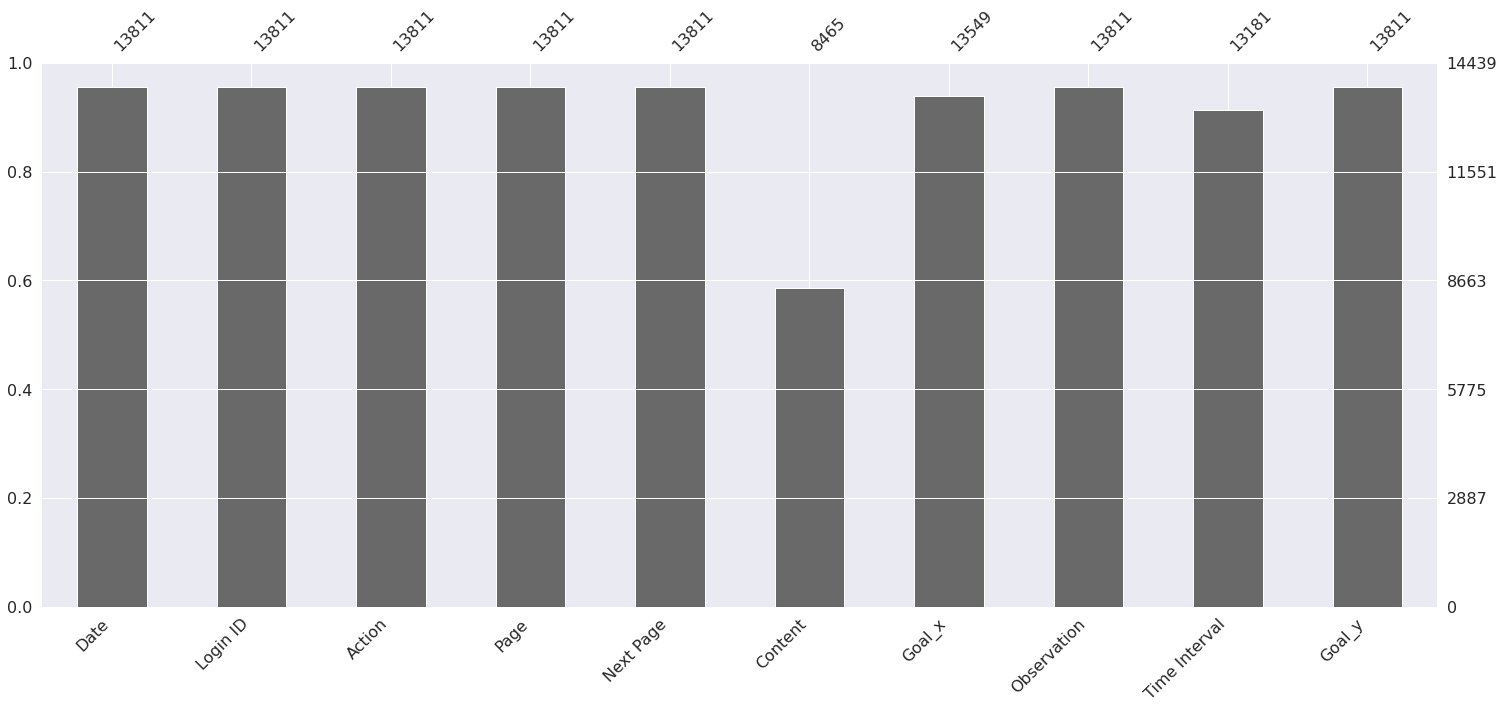

In [46]:
msno.bar(df_total)

La base unida tiene 14.439 eventos (filas) y 10 columnas. Todas las columnas presentan datos perdidos como se muestra en el gráfico, ya que no llegan a la altura de 14.439. El que más presenta perdidos es la variable Content seguido de Interval Time

El siguiente gráfico nos permite ver perdidos a nivel de filas

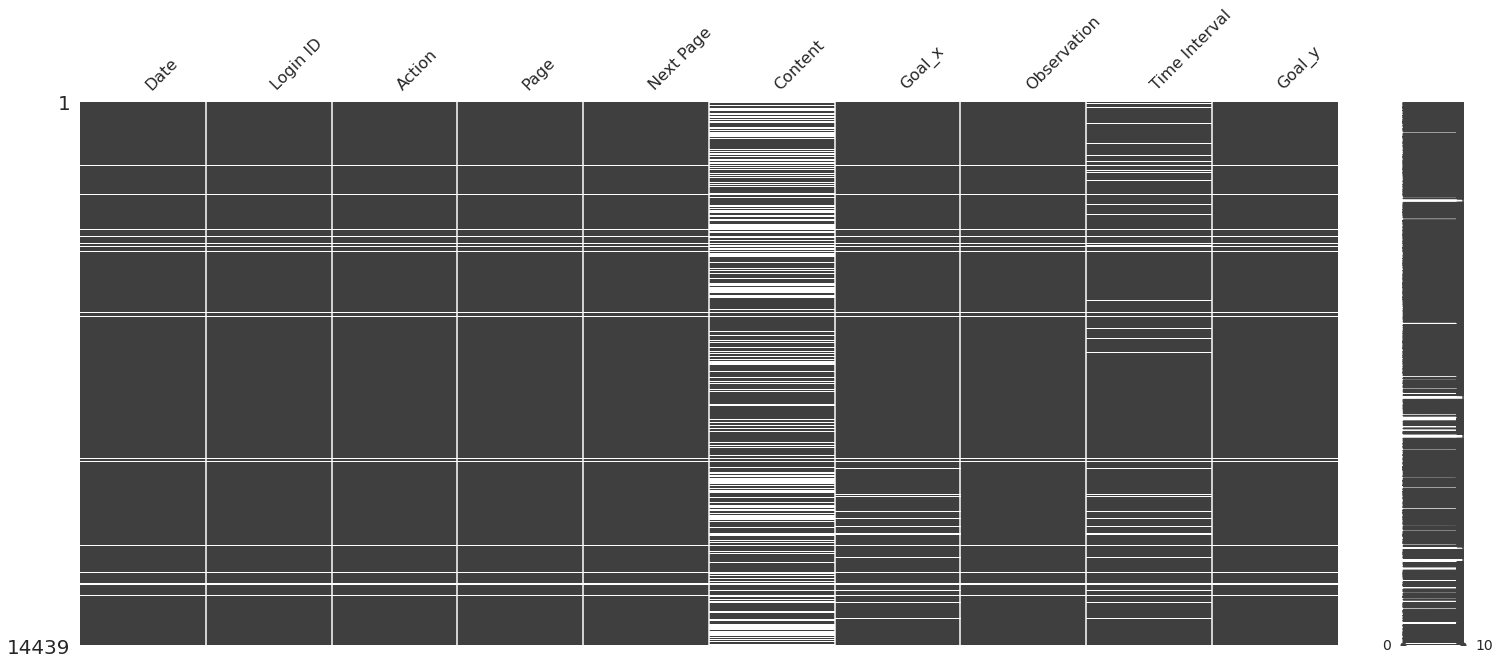

In [47]:
msno.matrix(df_total)

se puede observar que hay varías filas que tiene perdidos en todas las columnas. Esto se puede ver en la gráfica. La variable content es la que más presenta perdidos

Para verificar los datos perdidos, realizamos el filtro de los datos por la columna Date. En donde se observan 628 perdido en todas las columnas. Por lo que las podemos eliminar sin preocuparnos por perder información.

In [48]:
df_total[df_total['Date'].isna()]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y
9,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14288,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14314,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14334,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14355,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En esta parte nos quedamos con los diferentes a perdidos y nombramos la base como df2_total

In [49]:
df2_total=df_total[~(df_total['Date'].isna())]

Verificación de limpieza despues de eliminación de datos nulos.

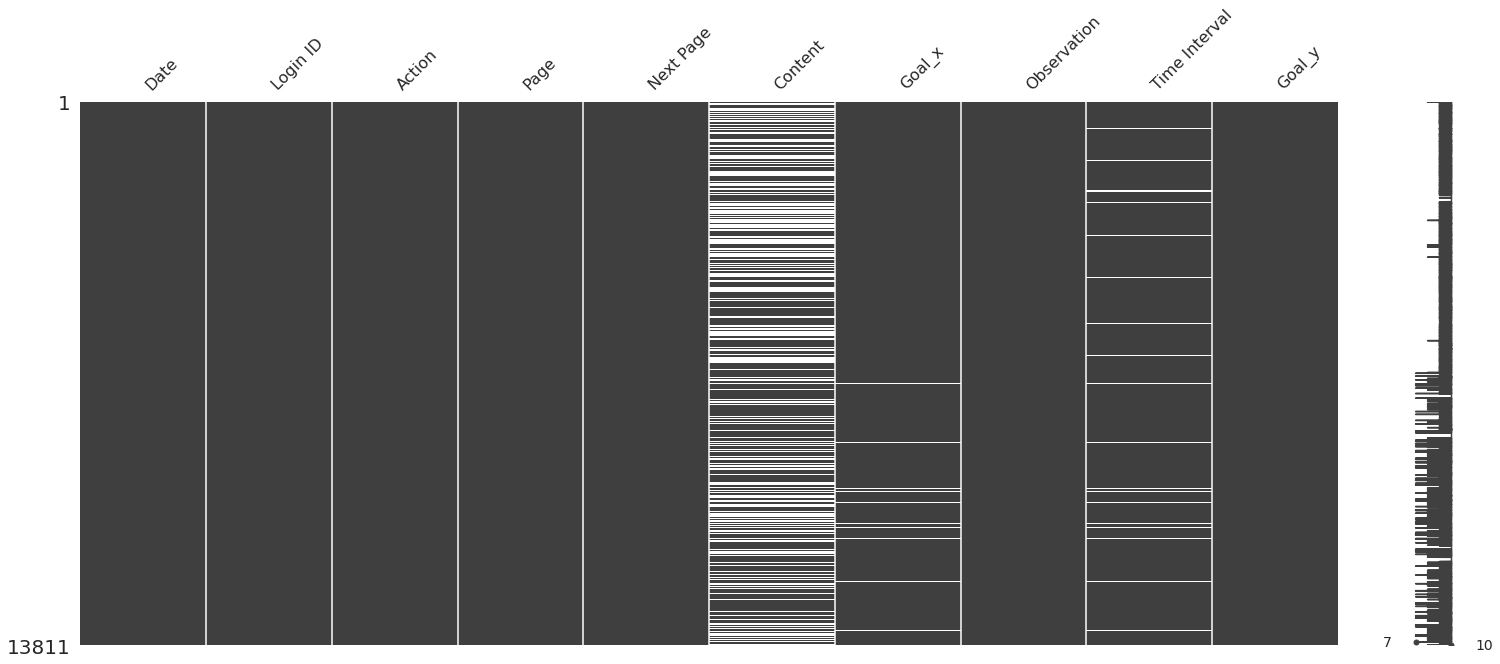

In [50]:
msno.matrix(df2_total)


Como se puede observar en la gráfica, los nulos se han eliminado a nivel de filas. Por otra parte también se puede observar que despues de la limpieza, la columna "Content", "Goal_x" y "Time Interval" tiene datos perdidos.

Ahora realizaremos nuevamente el analisis de perdidos

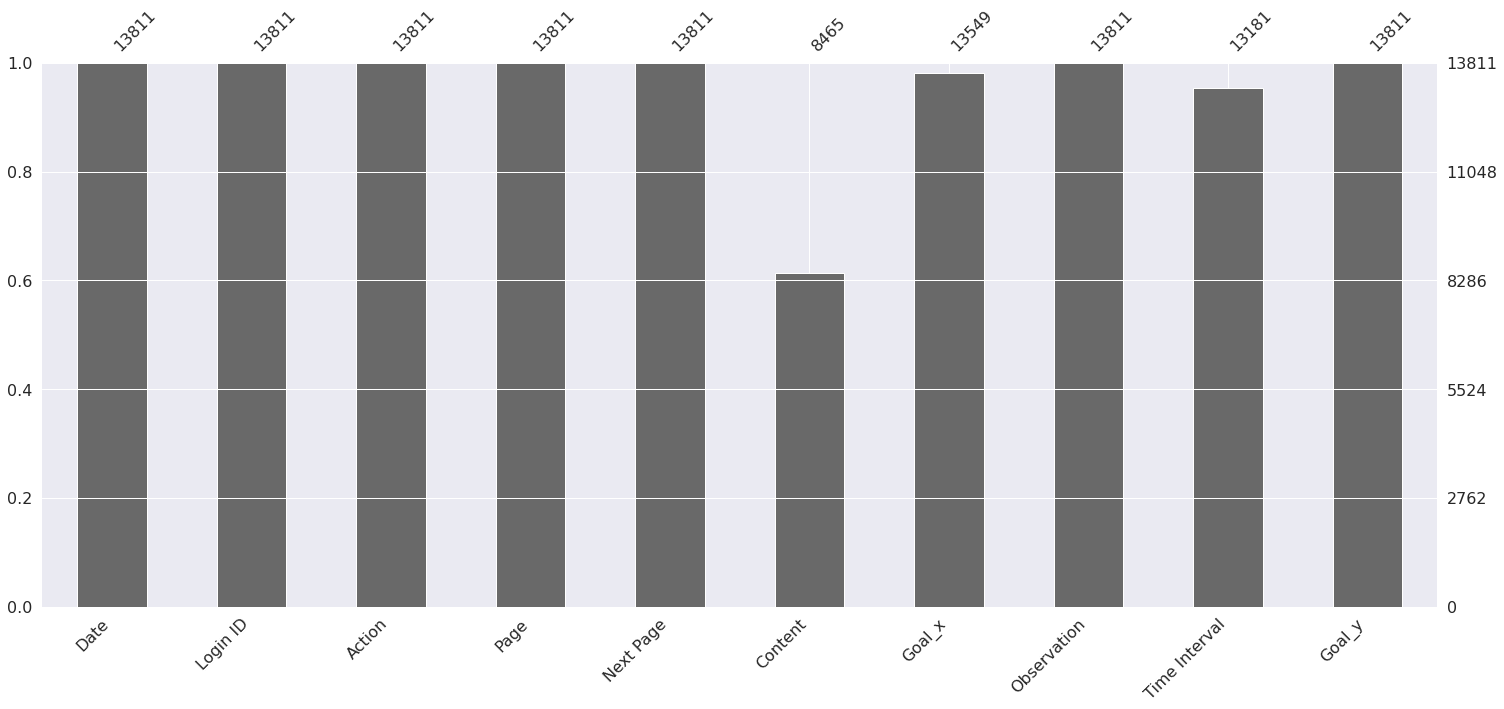

In [51]:
msno.bar(df2_total)

La variable "Time Interval", "Goal_x" y "Content" aún tiene datos perdidos.

 Para analizar cuales son para la columnas "Time Interval", realizaremos el filtro:

In [52]:
df2_total[df2_total['Time Interval'].isna()]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y
0,2014-09-19 06:08:30,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test,clickSkipPreQuestion,NaN,Test
10,2014-10-01 05:27:19,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test,clickSkipPreQuestion,NaN,Test
37,2014-10-07 20:58:48,user136,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:\n[Familiar] C,Test,clickSubmitPreQuestion&PreAnswer,NaN,Test
45,2014-09-22 01:28:12,user015,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:\n[Familiar] B,Test,clickSubmitPreQuestion&PreAnswer,NaN,Test
66,2014-09-23 13:29:49,user015,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:\n[Familiar] B,Test,clickSubmitPreQuestion&PreAnswer,NaN,Test
...,...,...,...,...,...,...,...,...,...,...
14289,2014-12-09 00:10:11,user196,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:#3#\n[Famili...,NaN,clickSubmitPreQuestion&PreAnswer,NaN,Test
14315,2014-12-12 21:46:53,user186,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:#3#\n[Famili...,NaN,clickSubmitPreQuestion&PreAnswer,NaN,Test
14335,2014-11-27 20:49:24,user188,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:#3#\n[Famili...,NaN,clickSubmitPreQuestion&PreAnswer,NaN,Test
14356,2014-12-17 00:35:28,user017,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,NaN,clickSkipPreQuestion,NaN,Test


Como se observa en la tabla 630 eventos presenta datos perdidos en la variable "Time Interval". Estos perdidos representa un bajo porcentaje, por lo que se pueden imputar con la media. Este proceso se realiza más adelante

Para la variable Content y Goal_x se puede manejar perdiso en la base. Por un lado Content es un campo que tiene demasiados perdidos y Goal_x la podemos analizar a través de Goal_y que no tiene perdidos

### Eventos por usuario base completa

Analizar los eventos por usuario nos puede dar indicios de usos poco usuales o maliciosos. Cuando un atacante intenta vulnerar un sistema por lo general genera muchos eventos.

In [53]:
df_users_total=pd.DataFrame(df2_total.value_counts('Login ID'))
df_users_total

,0
Login ID,
user049,1630
user051,351
user071,326
user037,315
user112,277
...,...
user245,43
user046,34
user211,34


De la tabla y de la distribución de la variable "n´mero de eventos, se observa que el "user049" generó 1630 logs por lo que se convierte en un usuario a revisar. Esto no es necesariamente un indicio de mal uso, por que puede ocurrir que sea un usuario operador como ocurrió en los analisis anteriores.

In [54]:
df_users_total.describe(percentiles=[0.05,0.25,0.5,0.75,0.80,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,80%,90%,99%,max
0,98.0,140.928571,169.451404,20.0,44.7,73.0,102.5,172.5,198.4,250.2,389.37,1630.0


En promedio cada usuario genera 140 eventos (logs). La mitad de los usuarios generó 102 eventos (mediana). Un usuario generó 1630 eventos

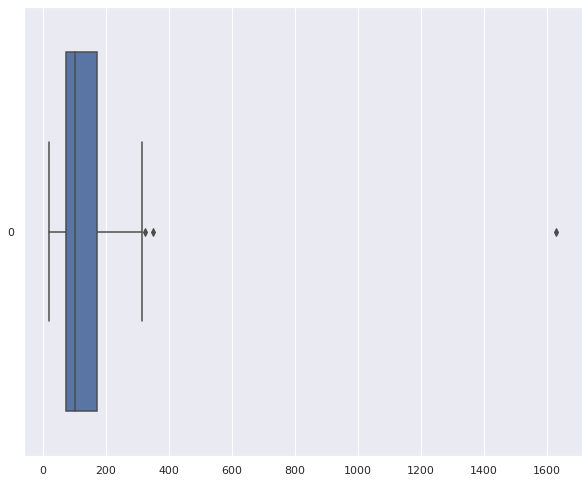

In [55]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.boxplot(data=df_users_total[0], orient="h",width=0.8)
plt.show()

En la gráfica de distribución de la variable "número de peticiones" se pueden observar como algunos usuarios se salen de la distribución normal de la variable por lo que se pueden revisar.

### Analisis de la variable accion base total

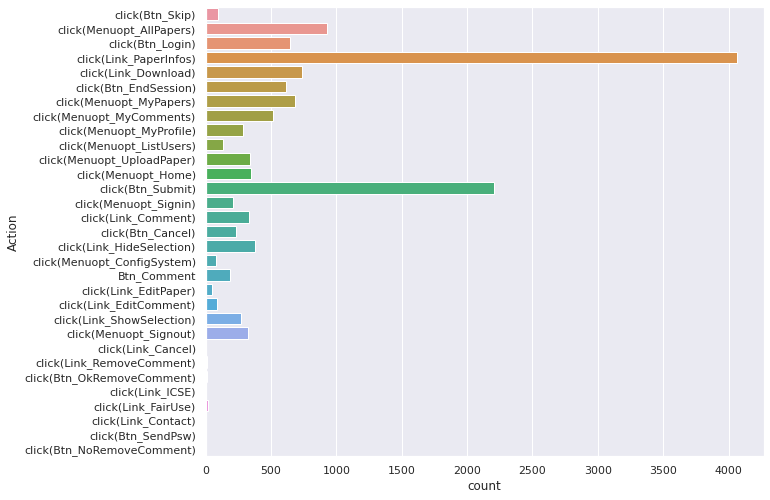

In [56]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df2_total, y='Action')
plt.show()

In [57]:
df2_total['Action'].value_counts(normalize=True)*100

click(Link_PaperInfos)         29.425820
click(Btn_Submit)              15.958294
click(Menuopt_AllPapers)        6.712041
click(Link_Download)            5.365289
click(Menuopt_MyPapers)         4.959815
click(Btn_Login)                4.662950
click(Btn_EndSession)           4.452972
click(Menuopt_MyComments)       3.743393
click(Link_HideSelection)       2.715227
click(Menuopt_Home)             2.498009
click(Menuopt_UploadPaper)      2.469046
click(Link_Comment)             2.418362
click(Menuopt_Signout)          2.367678
click(Menuopt_MyProfile)        2.056332
click(Link_ShowSelection)       1.954963
click(Btn_Cancel)               1.708783
click(Menuopt_Signin)           1.535008
Btn_Comment                     1.368474
click(Menuopt_ListUsers)        0.977482
click(Btn_Skip)                 0.680617
click(Link_EditComment)         0.637173
click(Menuopt_ConfigSystem)     0.572008
click(Link_EditPaper)           0.376511
click(Link_FairUse)             0.108609
click(Link_Remov

Del analisis de la variable Acción se observa que el 29.42% de los eventos se deben a click en "Link_PaperInfos" seguido de el boton "Btn_Submit" con 15.95%. Claramente es un indicio de que el sistema permite la carga de archivos.

### Analisis de la variable page base completa

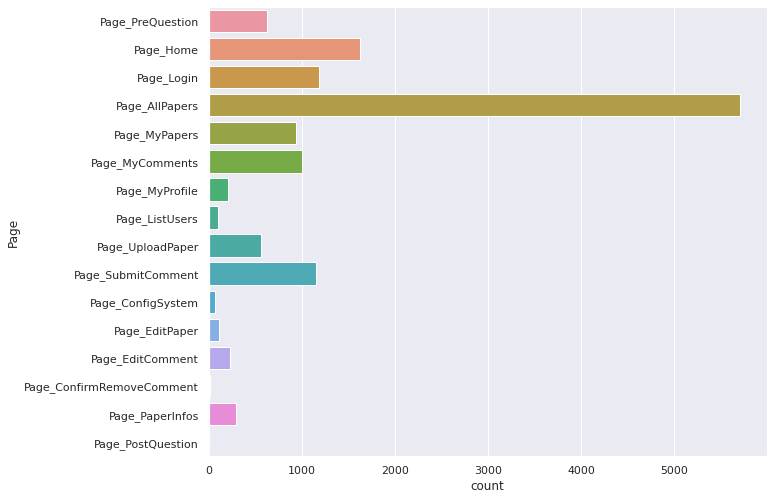

In [58]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df2_total, y='Page')
plt.show()

In [59]:
df2_total['Page'].value_counts(normalize=True)*100

Page_AllPapers               41.314894
Page_Home                    11.773224
Page_Login                    8.572877
Page_SubmitComment            8.319456
Page_MyComments               7.255087
Page_MyPapers                 6.806169
Page_PreQuestion              4.547100
Page_UploadPaper              4.054739
Page_PaperInfos               2.143219
Page_EditComment              1.658099
Page_MyProfile                1.477083
Page_EditPaper                0.796467
Page_ListUsers                0.702339
Page_ConfigSystem             0.477880
Page_ConfirmRemoveComment     0.094128
Page_PostQuestion             0.007241
Name: Page, dtype: float64

El 41.31% de los eventos ocurre por que los usuarios están en la pagina "Page_AllPapers" seguido de la pagina "Page_Home"

### Analisis de la variable Next Page base completa

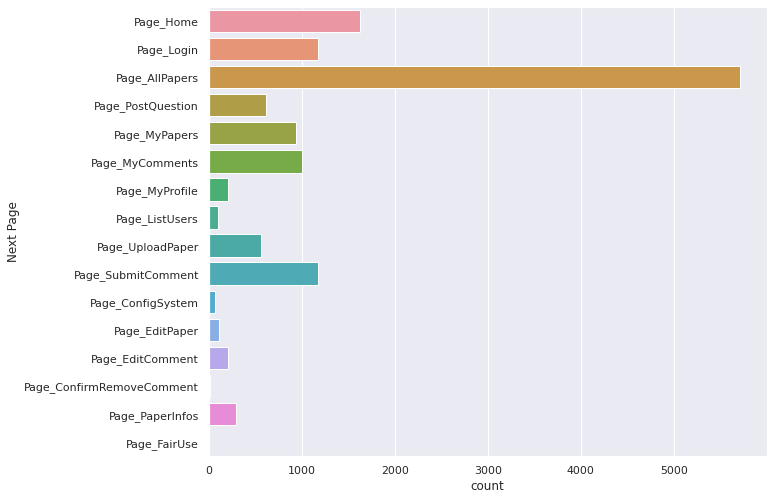

In [60]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df2_total, y='Next Page')
plt.show()

In [61]:
df2_total['Next Page'].value_counts(normalize=True)*100

Page_AllPapers               41.336616
Page_Home                    11.787705
Page_Login                    8.543914
Page_SubmitComment            8.522192
Page_MyComments               7.262327
Page_MyPapers                 6.798928
Page_PostQuestion             4.452972
Page_UploadPaper              4.076461
Page_PaperInfos               2.128738
Page_EditComment              1.520527
Page_MyProfile                1.484324
Page_EditPaper                0.803707
Page_ListUsers                0.702339
Page_ConfigSystem             0.463399
Page_ConfirmRemoveComment     0.094128
Page_FairUse                  0.021722
Name: Next Page, dtype: float64

el 41.33% de los usuarios va a la pagina "Page_AllPapers". Seguido de la página "Page_Home"

### Analisis de la variable Goal base completa

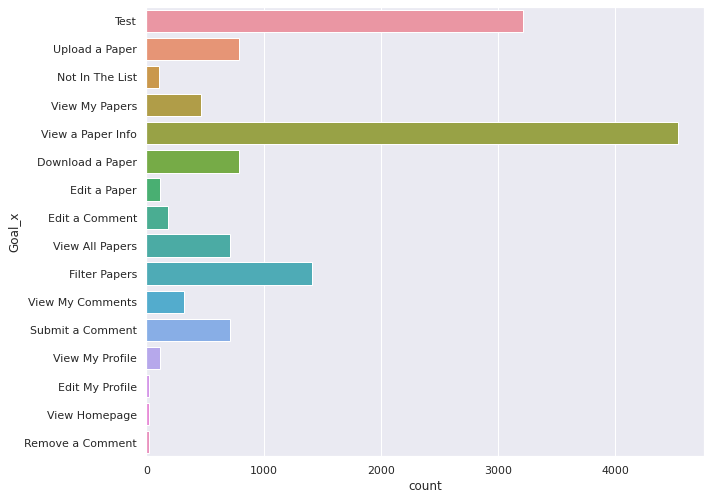

In [62]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df2_total, y='Goal_x')
plt.show()

In [63]:
df2_total['Goal_x'].value_counts(normalize=True)*100

View a Paper Info    33.471105
Test                 23.691785
Filter Papers        10.421433
Upload a Paper        5.852830
Download a Paper      5.808547
View All Papers       5.284523
Submit a Comment      5.277142
View My Papers        3.431988
View My Comments      2.369179
Edit a Comment        1.358034
Edit a Paper          0.878294
View My Profile       0.841391
Not In The List       0.804487
View Homepage         0.184515
Remove a Comment      0.169754
Edit My Profile       0.154993
Name: Goal_x, dtype: float64

El objetivo reportado corresponde en un 33.47%  a "View a Paper Info" seguido de Test en un 23.69%

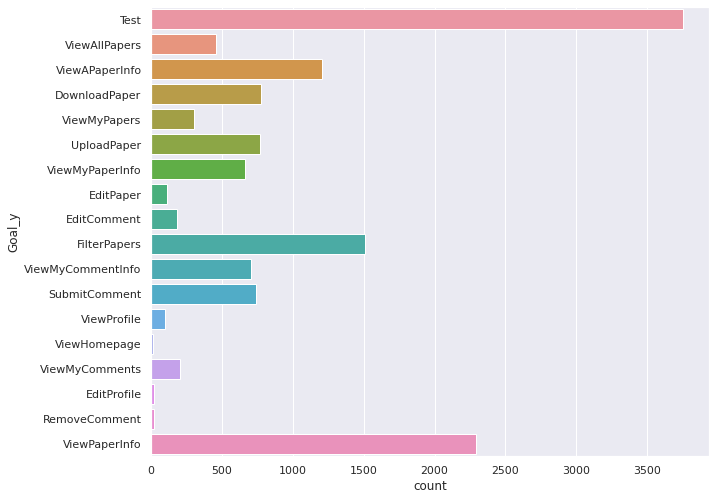

In [64]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.countplot(data=df2_total, y='Goal_y')
plt.show()

In [65]:
df2_total['Goal_y'].value_counts(normalize=True)*100

Test                 27.152270
ViewPaperInfo        16.595467
FilterPapers         10.911592
ViewAPaperInfo        8.746651
DownloadPaper         5.596988
UploadPaper           5.546304
SubmitComment         5.336326
ViewMyCommentInfo     5.082905
ViewMyPaperInfo       4.807762
ViewAllPapers         3.308957
ViewMyPapers          2.215625
ViewMyComments        1.462602
EditComment           1.339512
EditPaper             0.796467
ViewProfile           0.702339
RemoveComment         0.166534
EditProfile           0.144812
ViewHomepage          0.086887
Name: Goal_y, dtype: float64

Para el caso de la variable Goal_y, el 27.15% corresponde a Test, mientra que el 16.59% es "ViewPaperInfo". El 10.91% es de FilterPapers

### Analisis de la variable Observación

In [66]:
df2_total['Observation'].value_counts(normalize=True)*100

clickPaperInfosAllPapers&PaperID                                          14.104699
clickPaperInfos&PaperID                                                   11.179495
clickMenuAllPapers                                                         6.712041
clickMenuMyPapers                                                          4.959815
clickLogin&LoginGood                                                       4.481935
                                                                            ...    
clickFilter&FilterPublicationTypeCategory                                  0.007241
clickSubmitComment&NoCategoryShortProblemSolvedLimitation                  0.007241
clickSubmitComment&ShortProblemSolvedLimitation                            0.007241
clickSubmitComment&NoCategoryShortMethodologyTechnicalMeritsLimitation     0.007241
clickLinkContact                                                           0.007241
Name: Observation, Length: 202, dtype: float64

Para el caso de la variable "Observation" el 14.10% corresponde a clickPaperInfosAllPapers&PaperID 11.19%. a clickPaperInfos&PaperID  y un 6.7% corresponde a clickMenuAllPapers

Podría pensarse en la variable Test como una variable de prueba, sin embargo no se encuentra eventos maliciosos que hagan sospechar de un mal uso a pesar de estar etiquetadas como Test.

In [67]:
df2_total[(df2_total['Goal_x']=='Test') |(df2_total['Goal_y']=='Test')]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y
0,2014-09-19 06:08:30,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test,clickSkipPreQuestion,NaN,Test
1,2014-09-19 06:08:52,user136,click(Menuopt_AllPapers),Page_Home,Page_Login,NaN,Test,clickMenuAllPapers,30s,ViewAllPapers
2,2014-09-19 06:09:19,user136,click(Btn_Login),Page_Login,Page_Home,[Login ID]KatsunoriOyama [Password]271adc [Mes...,Test,clickLogin&LoginGood,30s,ViewAllPapers
3,2014-09-19 06:09:34,user136,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,NaN,Test,clickMenuAllPapers,20s,ViewAllPapers
4,2014-09-19 06:11:21,user136,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,[paper ID]1408576997,Test,clickPaperInfos&PaperID,m,ViewAPaperInfo
...,...,...,...,...,...,...,...,...,...,...
14424,2014-12-17 01:06:48,user017,click(Menuopt_Signout),Page_AllPapers,Page_Login,NaN,Test,clickMenuSignout,m,Test
14425,2014-12-17 01:06:49,user017,click(Btn_EndSession),Page_Login,Page_PostQuestion,NaN,Test,clickEndSession,5s,Test
14427,2015-01-09 05:39:05,user083,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:#3#\n[Famili...,NaN,clickSubmitPreQuestion&PreAnswer,NaN,Test
14437,2015-01-09 05:41:53,user083,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,[paper ID]1420802620,Not In The List,clickEditPaperMyPapers&PaperID,5s,Test


### Analisis de la variable Time base completa

Ahora vamos a analizar como es la tabla de frecuencias de los tiempos en acciones consecutivas en el sistema

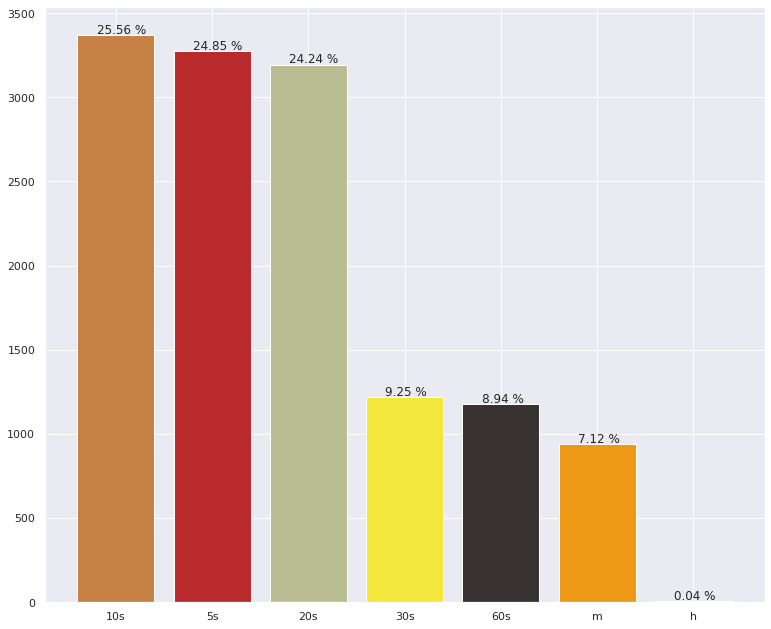

In [68]:
df_time=df2_total['Time Interval'].value_counts()
df_time=df_time.to_frame()
df_time_precent=df2_total['Time Interval'].value_counts(normalize=True)*100
df_time_precent=df_time_precent.to_frame()
absolut_values=list(df_time['Time Interval'])
relative_values=list(df_time_precent['Time Interval'])
number_list=list(range(0,7))

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
time = df_time.index
bar_colors = ['#c68145', '#b82a2c', '#babc91', '#f4e73c','#383331','#ed9916']
frec =df_time['Time Interval']
ax.bar(time,frec,color=bar_colors)
for ind, m, n in zip(number_list,absolut_values,relative_values):
    ax.text(ind-0.2,m+10,str(round(n,2))+" %")
plt.show()

De acuerdo a la gráfica, el 25.56% de los eventos tiene una duración de 10 segundos, el 24.85% tiene una duración de 5 segundos. El 24.24% tiene una duración de 20 segundos. Los eventos que tiene duración en el orden de las horas son muy pocos

### Tranformación de la variable Time

Es necesario limpiar y transformar la variable Time para poder trabajarla como una variale numerica en la base de datos. Para esto procesamos la variable con la función CastToInt

In [69]:
timeNumeric=df2_total['Time Interval'].apply(castToInt)
df2_total['TimeNumeric']=timeNumeric
df2_total

<ipython-input-69-d226803160d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_total['TimeNumeric']=timeNumeric


,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric
0,2014-09-19 06:08:30,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test,clickSkipPreQuestion,NaN,Test,21
1,2014-09-19 06:08:52,user136,click(Menuopt_AllPapers),Page_Home,Page_Login,NaN,Test,clickMenuAllPapers,30s,ViewAllPapers,30
2,2014-09-19 06:09:19,user136,click(Btn_Login),Page_Login,Page_Home,[Login ID]KatsunoriOyama [Password]271adc [Mes...,Test,clickLogin&LoginGood,30s,ViewAllPapers,30
3,2014-09-19 06:09:34,user136,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,NaN,Test,clickMenuAllPapers,20s,ViewAllPapers,20
4,2014-09-19 06:11:21,user136,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,[paper ID]1408576997,Test,clickPaperInfos&PaperID,m,ViewAPaperInfo,60
...,...,...,...,...,...,...,...,...,...,...,...
14434,2015-01-09 05:40:35,user083,click(Link_Comment),Page_MyPapers,Page_SubmitComment,[paper ID]1420802620,View My Comments,clickSubmitCommentMyPapers&PaperID,20s,SubmitComment,20
14435,2015-01-09 05:41:37,user083,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,NaN,View My Comments,clickMenuAllPapers,m,ViewAllPapers,60
14436,2015-01-09 05:41:49,user083,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,NaN,Not In The List,clickMenuMyPapers,20s,ViewMyPapers,20
14437,2015-01-09 05:41:53,user083,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,[paper ID]1420802620,Not In The List,clickEditPaperMyPapers&PaperID,5s,Test,5


Y con la variable Time en formato numerico podemos realizar el analisis descriptico de dicha variable.

In [70]:
df2_total.describe(percentiles=[0.05,0.25,0.5,0.75,0.80,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,80%,90%,99%,max
TimeNumeric,13811.0,22.358265,70.474199,5.0,5.0,10.0,20.0,21.0,30.0,60.0,60.0,3600.0


En promedio los usuarios del sistema permanecen aproximadamente 22 segundos en alguna parte de la página antes de realizar otra acción.

### Horarios normales de uso del sistema

Es posible adicionalmente crear una variable dummy identificando los horarios de uso normal del sistema. Para lograrlo creamos el siguiente dataframe.

In [71]:
datetimes = df2_total['Date']
datetimes=pd.DataFrame(datetimes)

In [72]:
datetimes['year']=datetimes['Date'].dt.year
datetimes['month']=datetimes['Date'].dt.month
datetimes['day']=datetimes['Date'].dt.day
datetimes['hour']=datetimes['Date'].dt.hour
datetimes

,Date,year,month,day,hour
0,2014-09-19 06:08:30,2014,9,19,6
1,2014-09-19 06:08:52,2014,9,19,6
2,2014-09-19 06:09:19,2014,9,19,6
3,2014-09-19 06:09:34,2014,9,19,6
4,2014-09-19 06:11:21,2014,9,19,6
...,...,...,...,...,...
14434,2015-01-09 05:40:35,2015,1,9,5
14435,2015-01-09 05:41:37,2015,1,9,5
14436,2015-01-09 05:41:49,2015,1,9,5
14437,2015-01-09 05:41:53,2015,1,9,5


Con el dataframe creado, realizamos un diagrama de barras:

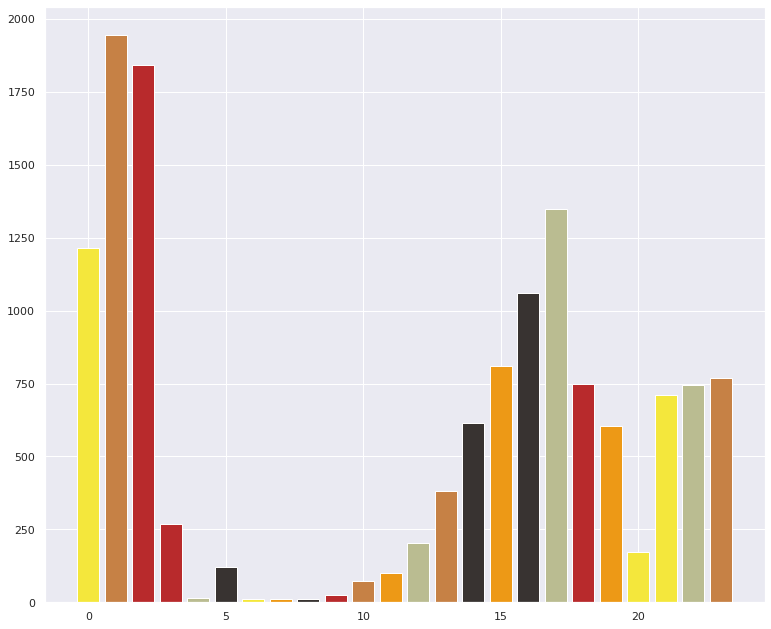

In [73]:
df_time=datetimes['hour'].value_counts()
df_time=df_time.to_frame()
df_time_precent=datetimes['hour'].value_counts(normalize=True)*100
df_time_precent=df_time_precent.to_frame()
absolut_values=list(df_time['hour'])
relative_values=list(df_time_precent['hour'])
number_list=list(range(0,len(df_time)))

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
time = df_time.index
bar_colors = ['#c68145', '#b82a2c', '#babc91', '#f4e73c','#383331','#ed9916']
frec =df_time['hour']
ax.bar(time,frec,color=bar_colors)
plt.show()

Podría decirse que los horarios normales de uso del sistema empiezan aproximadamente a las 9 de la mañana hasta las 10 o 11 de la noche. Se observan picos de conexiones a las 12 de la noche,1 de la mañana y 2 de la mañana que se deberían revisar.

Añadimos la hora como una nueva columna para poder construir la variable dummy

In [74]:
#df2_total['year']=df2_total['Date'].dt.year
#df2_total['month']=df2_total['Date'].dt.month
#df2_total['day']=df2_total['Date'].dt.day
df2_total['hour']=df2_total['Date'].dt.hour
df2_total

<ipython-input-74-af5899dcacb1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_total['hour']=df2_total['Date'].dt.hour


,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour
0,2014-09-19 06:08:30,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test,clickSkipPreQuestion,NaN,Test,21,6
1,2014-09-19 06:08:52,user136,click(Menuopt_AllPapers),Page_Home,Page_Login,NaN,Test,clickMenuAllPapers,30s,ViewAllPapers,30,6
2,2014-09-19 06:09:19,user136,click(Btn_Login),Page_Login,Page_Home,[Login ID]KatsunoriOyama [Password]271adc [Mes...,Test,clickLogin&LoginGood,30s,ViewAllPapers,30,6
3,2014-09-19 06:09:34,user136,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,NaN,Test,clickMenuAllPapers,20s,ViewAllPapers,20,6
4,2014-09-19 06:11:21,user136,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,[paper ID]1408576997,Test,clickPaperInfos&PaperID,m,ViewAPaperInfo,60,6
...,...,...,...,...,...,...,...,...,...,...,...,...
14434,2015-01-09 05:40:35,user083,click(Link_Comment),Page_MyPapers,Page_SubmitComment,[paper ID]1420802620,View My Comments,clickSubmitCommentMyPapers&PaperID,20s,SubmitComment,20,5
14435,2015-01-09 05:41:37,user083,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,NaN,View My Comments,clickMenuAllPapers,m,ViewAllPapers,60,5
14436,2015-01-09 05:41:49,user083,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,NaN,Not In The List,clickMenuMyPapers,20s,ViewMyPapers,20,5
14437,2015-01-09 05:41:53,user083,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,[paper ID]1420802620,Not In The List,clickEditPaperMyPapers&PaperID,5s,Test,5,5


Una vez que hemos separado la hora en una nueva columa creamos la siguiente regla: Si el uso de la página web esta entre las 4 de la mañana y las 23 se asigna un cero y corresponde a uso tipico. Si el acceso esta entre las 0 horas y las 3 de la mañana se asigna un 1 y se considera un horario poco usual

In [75]:
conditions = [ 
    ((df2_total['hour']>=4) & (df2_total['hour']<=23)),
    ((df2_total['hour']<4))
]
values = [0,1]
df2_total['horarios'] =np.select(conditions,values)

<ipython-input-75-de202dcc18b2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_total['horarios'] =np.select(conditions,values)


In [76]:
df2_total

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios
0,2014-09-19 06:08:30,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test,clickSkipPreQuestion,NaN,Test,21,6,0
1,2014-09-19 06:08:52,user136,click(Menuopt_AllPapers),Page_Home,Page_Login,NaN,Test,clickMenuAllPapers,30s,ViewAllPapers,30,6,0
2,2014-09-19 06:09:19,user136,click(Btn_Login),Page_Login,Page_Home,[Login ID]KatsunoriOyama [Password]271adc [Mes...,Test,clickLogin&LoginGood,30s,ViewAllPapers,30,6,0
3,2014-09-19 06:09:34,user136,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,NaN,Test,clickMenuAllPapers,20s,ViewAllPapers,20,6,0
4,2014-09-19 06:11:21,user136,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,[paper ID]1408576997,Test,clickPaperInfos&PaperID,m,ViewAPaperInfo,60,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14434,2015-01-09 05:40:35,user083,click(Link_Comment),Page_MyPapers,Page_SubmitComment,[paper ID]1420802620,View My Comments,clickSubmitCommentMyPapers&PaperID,20s,SubmitComment,20,5,0
14435,2015-01-09 05:41:37,user083,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,NaN,View My Comments,clickMenuAllPapers,m,ViewAllPapers,60,5,0
14436,2015-01-09 05:41:49,user083,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,NaN,Not In The List,clickMenuMyPapers,20s,ViewMyPapers,20,5,0
14437,2015-01-09 05:41:53,user083,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,[paper ID]1420802620,Not In The List,clickEditPaperMyPapers&PaperID,5s,Test,5,5,0


Ahora analicemos como son los eventos generados en horarios poco habituales. Los que se marcaron con el número 1

In [77]:
df2_total[df2_total['horarios']==1]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios
45,2014-09-22 01:28:12,user015,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:\n[Familiar] B,Test,clickSubmitPreQuestion&PreAnswer,NaN,Test,21,1,1
46,2014-09-22 01:28:20,user015,click(Menuopt_ListUsers),Page_Home,Page_Login,NaN,Test,clickMenuListUsers,10s,Test,10,1,1
47,2014-09-22 01:28:24,user015,click(Menuopt_Home),Page_Login,Page_Home,NaN,Test,clickMenuHome,5s,Test,5,1,1
48,2014-09-22 01:28:40,user015,click(Menuopt_MyProfile),Page_Home,Page_Login,NaN,Test,clickMenuMyProfile,20s,Test,20,1,1
49,2014-09-22 01:28:43,user015,click(Menuopt_AllPapers),Page_Login,Page_Login,NaN,Test,clickMenuAllPapers,5s,Test,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14421,2014-12-17 01:05:23,user017,click(Btn_Submit),Page_SubmitComment,Page_SubmitComment,[paper ID] 1418761353#3#\n[FORM_Overall] 3#3#\...,Submit a Comment,clickSubmitComment&CommentInfoGood,m,SubmitComment,60,1,1
14422,2014-12-17 01:05:28,user017,click(Link_PaperInfos),Page_SubmitComment,Page_SubmitComment,[paper ID]1418761353,View a Paper Info,clickPaperInfosSubmitComment&PaperID,10s,ViewPaperInfo,10,1,1
14423,2014-12-17 01:05:43,user017,click(Menuopt_AllPapers),Page_SubmitComment,Page_AllPapers,NaN,View All Papers,clickMenuAllPapers,20s,ViewAllPapers,20,1,1
14424,2014-12-17 01:06:48,user017,click(Menuopt_Signout),Page_AllPapers,Page_Login,NaN,Test,clickMenuSignout,m,Test,60,1,1


Analicemos algún usuario:

In [78]:
df2_total[df2_total['Login ID']=='user255']

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios
11139,2014-12-11 00:46:27,user255,click(Btn_Submit),Page_PreQuestion,Page_Home,Pre-Session Questionnaire Answers:#3#\n[Famili...,NaN,clickSubmitPreQuestion&PreAnswer,NaN,Test,21,0,1
11140,2014-12-11 00:46:31,user255,click(Menuopt_Home),Page_Home,Page_Home,NaN,Test,clickMenuHome,5s,Test,5,0,1
11141,2014-12-11 00:46:34,user255,click(Menuopt_Signin),Page_Home,Page_Login,NaN,Test,clickMenuSignin,5s,Test,5,0,1
11142,2014-12-11 00:46:40,user255,click(Menuopt_AllPapers),Page_Login,Page_Login,NaN,Test,clickMenuAllPapers,10s,Test,10,0,1
11143,2014-12-11 00:46:42,user255,click(Menuopt_MyProfile),Page_Login,Page_Login,NaN,Test,clickMenuMyProfile,5s,Test,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11229,2014-12-15 01:37:25,user255,click(Btn_Submit),Page_SubmitComment,Page_SubmitComment,[paper ID] 1408601700#3#\n[FORM_Overall] 4#3#\...,Submit a Comment,clickSubmitComment&CommentInfoGood,m,SubmitComment,60,1,1
11230,2014-12-15 01:37:26,user255,click(Btn_Submit),Page_EditComment,Page_EditComment,[paper ID] 1408601700#3#\n[DTBS_Overall] 4#3#\...,Submit a Comment,clickSubmitEditComment&CommentInfoGood,5s,SubmitComment,5,1,1
11231,2014-12-15 01:37:34,user255,click(Link_PaperInfos),Page_EditComment,Page_EditComment,[paper ID]1408601700,View a Paper Info,clickPaperInfosEditComment&PaperID,10s,ViewPaperInfo,10,1,1
11232,2014-12-15 01:37:47,user255,click(Menuopt_Signout),Page_EditComment,Page_Login,NaN,Test,clickMenuSignout,20s,Test,20,1,1


El "user255" generó todas sus peticiones en horarios no habituales, sin emabargo no se encuentran peticiones sospechosas.

### Descriptivos del horario habitual y no habitual

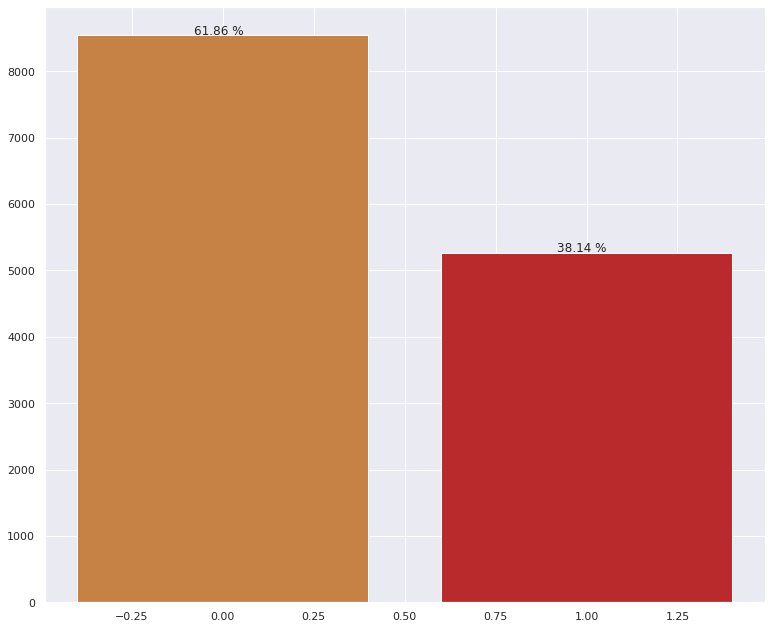

In [79]:
df_time=df2_total['horarios'].value_counts()
df_time=df_time.to_frame()
df_time_precent=df2_total['horarios'].value_counts(normalize=True)*100
df_time_precent=df_time_precent.to_frame()

absolut_values=list(df_time['horarios'])
relative_values=list(df_time_precent['horarios'])
number_list=list(range(0,len(df_time)))

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
time = list(df_time.index)
bar_colors = ['#c68145', '#b82a2c']
frec =df_time['horarios']
ax.bar(time,frec,color=bar_colors)
ax.xaxis
for ind, m, n in zip(number_list,absolut_values,relative_values):
    ax.text(ind-0.08,m+10,str(round(n,2))+" %")
plt.show()

El 61.86% de los eventos se generaron en horarios habituales. El 38.14% de los eventos se generaron en horarios poco habituales.

### Buscando peticiones maliciosas en la variable "Content"

Como se había mencionado, el campo Content, es de particular interes debido a que en este campo quedan registradas las peticiones al servidor, por lo que es posible buscar peticiones maliciosas tales como XSS, SQL injection, carga de archivos tipo payload

Es importante mencionar que estos campos los podemos ver debido a que las peticiones se realizan por el protocolo HTTP el cúal no cifra los datos, esta es la razón por la que también se observan las contraseñas de los usuarios en texto plano.




Debido a que los logs quedan en texto plano, es posible identificar peticione maliciosas y entrenar un modelo que las indentifique automáticamente

In [80]:
# buscando peticiones tipo XSS
df2_total[df2_total['Content'].str.contains("</script>",na=False)]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios
9184,2014-12-18 13:54:04,user059,click(Btn_Submit),Page_EditComment,Page_EditComment,[paper ID] 1418847421#3#\n[DTBS_Overall] 3#3#\...,Submit a Comment,clickSubmitEditComment&CommentInfoGood,60s,EditComment,60,13,0
9188,2014-12-18 13:55:37,user059,click(Btn_Submit),Page_EditComment,Page_EditComment,[paper ID] 1418847421#3#\n[DTBS_Overall] 3#3#\...,Edit a Comment,clickSubmitEditComment&CommentInfoGood,60s,EditComment,60,13,0


Se encontraron dos peticiones probablemente maliciosas, dedido a que se editan los comentarios y se mete entre lineas codigo javascript e intentando la ejecución de código php:

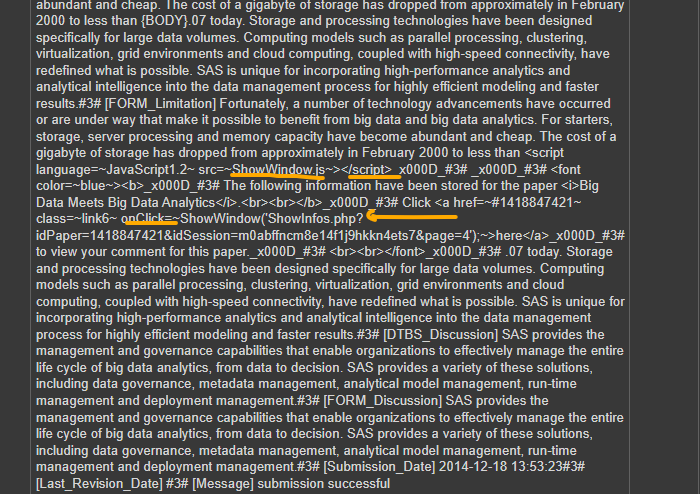

In [81]:
# buscando ejecutables tipo .php
df2_total[df2_total['Content'].str.contains(".php",na=False)]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios
9184,2014-12-18 13:54:04,user059,click(Btn_Submit),Page_EditComment,Page_EditComment,[paper ID] 1418847421#3#\n[DTBS_Overall] 3#3#\...,Submit a Comment,clickSubmitEditComment&CommentInfoGood,60s,EditComment,60,13,0
9188,2014-12-18 13:55:37,user059,click(Btn_Submit),Page_EditComment,Page_EditComment,[paper ID] 1418847421#3#\n[DTBS_Overall] 3#3#\...,Edit a Comment,clickSubmitEditComment&CommentInfoGood,60s,EditComment,60,13,0


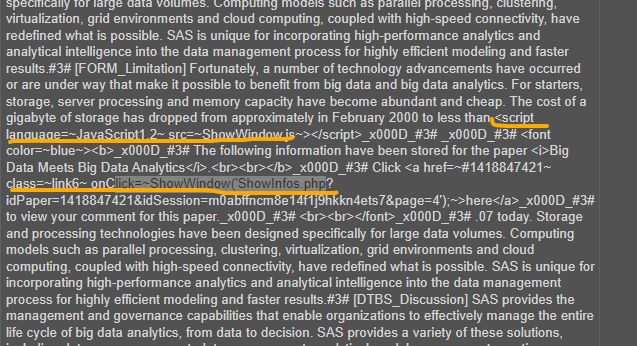

In [82]:
# buscando peticiones maliciosas tipo XSS
df2_total[df2_total['Content'].str.contains("alert()",na=False)]

<ipython-input-82-026384dbc32e>:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df2_total[df2_total['Content'].str.contains("alert()",na=False)]


,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios
6813,2014-10-01 16:34:55,user077,click(Btn_Submit),Page_SubmitComment,Page_SubmitComment,[paper ID] NULL\n[FORM_Overall] 3\n[FORM_Categ...,Upload a Paper,clickSubmitComment&NoCategory,m,UploadPaper,60,16,0
6814,2014-10-01 16:35:41,user077,click(Btn_Submit),Page_SubmitComment,Page_SubmitComment,[paper ID] NULL\n[FORM_Overall] 3\n[FORM_Categ...,Upload a Paper,clickSubmitComment&CommentGood,60s,UploadPaper,60,16,0
9761,2014-12-17 13:06:58,user188,click(Btn_Submit),Page_SubmitComment,Page_SubmitComment,[paper ID] 1418372248#3#\n[FORM_Overall] 4#3#\...,Submit a Comment,clickSubmitComment&ShortMethodologyShortLimita...,m,SubmitComment,60,13,0
9762,2014-12-17 13:08:27,user188,click(Btn_Submit),Page_SubmitComment,Page_SubmitComment,[paper ID] 1418372248#3#\n[FORM_Overall] 4#3#\...,Submit a Comment,clickSubmitComment&CommentInfoGood,m,SubmitComment,60,13,0
9764,2014-12-17 13:09:54,user188,click(Btn_Submit),Page_EditComment,Page_EditComment,[paper ID] 1418372248#3#\n[DTBS_Overall] 4#3#\...,Edit a Comment,clickSubmitEditComment&CommentInfoGood,m,EditComment,60,13,0


In [83]:
df2_total[df2_total['Content'].str.contains(".js",na=False)]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios
9184,2014-12-18 13:54:04,user059,click(Btn_Submit),Page_EditComment,Page_EditComment,[paper ID] 1418847421#3#\n[DTBS_Overall] 3#3#\...,Submit a Comment,clickSubmitEditComment&CommentInfoGood,60s,EditComment,60,13,0
9188,2014-12-18 13:55:37,user059,click(Btn_Submit),Page_EditComment,Page_EditComment,[paper ID] 1418847421#3#\n[DTBS_Overall] 3#3#\...,Edit a Comment,clickSubmitEditComment&CommentInfoGood,60s,EditComment,60,13,0
9898,2014-12-14 18:08:38,user196,click(Btn_Submit),Page_SubmitComment,Page_SubmitComment,[paper ID] 1411623323#3#\n[FORM_Overall] 4#3#\...,Submit a Comment,clickSubmitComment&ShortTechnicalMeritsShortLi...,m,SubmitComment,60,18,0
9899,2014-12-14 18:09:29,user196,click(Btn_Submit),Page_SubmitComment,Page_SubmitComment,[paper ID] 1411623323#3#\n[FORM_Overall] 4#3#\...,Submit a Comment,clickSubmitComment&CommentInfoGood,60s,SubmitComment,60,18,0
9901,2014-12-14 18:11:11,user196,click(Btn_Submit),Page_EditComment,Page_EditComment,[paper ID] 1411623323#3#\n[DTBS_Overall] 4#3#\...,View a Paper Info,clickSubmitEditComment&CommentInfoGood,m,EditComment,60,18,0


Es posible que la petición mostrada sea maliciosa

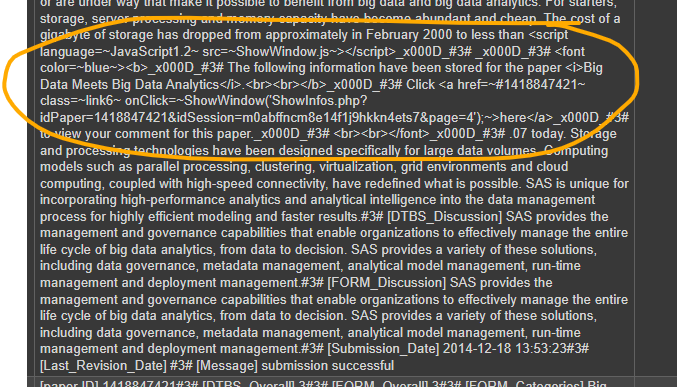

In [84]:
# buscando injection SQL
df2_total[df2_total['Content'].str.contains("OR 1=1",na=False)]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios


In [85]:
# buscando injection SQL
df2_total[df2_total['Content'].str.contains("1=1",na=False)]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios


In [86]:
# buscando injection SQL
df2_total[df2_total['Content'].str.contains('" or ""="',na=False)]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios


In [87]:
# buscando injection SQL
df2_total[df2_total['Content'].str.contains('@0',na=False)]

,Date,Login ID,Action,Page,Next Page,Content,Goal_x,Observation,Time Interval,Goal_y,TimeNumeric,hour,horarios


## Identificación de anomalias por usuarios

Es posible realizar un analisis avanzado de detección de anomalías con las variables con las que disponemos y sobre todo con la columna "Content" ya que es un campo muy particular debido a que aqui quedan registrados los comentarios, edición de comentarios y publicaciones, las cuales son de particular interes por los usuarios maliciosos los cuales intentan realizar cross site scripting reflejado o almacenado, intenta realizar inyeccion sql o cargar un payload malicioso. Este campo debe trabajarse a través de NLP y podría entrenarse con BERT siempre y cuando tengamos identificado que petición corresponde a una petición maliciosa. Este analisis se realizaría por evento o log

Otro enfoque un poco más sencillo pero practico y rápido es realizar el analisis por usuarios. Teniendo en cuenta el número de peticiones que realiza un usuario, el tiempo acumulado de este en el sistema y un indice de uso relacionado al horario, el cual se computa a través del promedio de uso en horario normal y uso en horario poco normales. (Si el usuario ingresa en horario normal se le asigan un 0 (de 4 a 23), si lo hace en un horario poco usual se le asiga el númeor 1. Es una variable dummy. Al realizar el promedio esta variable se convierte en un indice entre 0 y 1 (de 0 a 3) en donde 1 es que el usuario realizó todas las peticiones en horarios poco usuales y valores bajo son horarios normales de uso del sistema)

In [88]:
df2_total['NroPeticiones']=1
df_users=df2_total.groupby('Login ID',as_index=True).agg(
                                  {'TimeNumeric':'sum',
                                  'NroPeticiones':'sum',
                                   'horarios':'mean'
                                   })

<ipython-input-88-88a666d1e046>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_total['NroPeticiones']=1


La implementación de la detección de anomalias se realizó utilizando OneClassSVM, librería de sklearn que utiliza maquinas de soporte vectorial y en este caso particual sirve para problemas de aprendizaje no supervisado (sin label).


Antes de instanciar la el objeto de la clase OneClassSVM es importante normalizar los datos

In [89]:
scalerSVC_test=StandardScaler()
data_test_scaled=scalerSVC_test.fit_transform(df_users)

El entrenamiento del modelo para identificar anomalías se parametriza con un kernel rbf:

In [90]:
clf = OneClassSVM(kernel='rbf', gamma='scale',nu=0.5).fit(data_test_scaled)

Entrenado el modelo, podemos realizar las respectivas predicciones para identiifcar anomalias a nivel de usuario

In [91]:
clf.predict(data_test_scaled)

array([ 1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1,
       -1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1,  1,
        1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1,
        1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1,
        1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1])

Añadimos en le dataset la clasificación de anomalia da por -1 y el respectivo score

In [92]:
df_users['label']=clf.predict(data_test_scaled)
df_users['score']=clf.score_samples(data_test_scaled)
df_users

,TimeNumeric,NroPeticiones,horarios,label,score
Login ID,,,,,
user012,2246,103,0.427184,1,23.407841
user015,4033,178,0.303371,1,23.157559
user017,4189,162,0.493827,1,22.777957
user018,1857,96,0.604167,1,22.389587
user020,1809,73,0.178082,1,22.037406
...,...,...,...,...,...
user249,2029,106,0.405660,1,23.372246
user252,3510,171,0.257310,1,23.309744
user255,1290,91,1.000000,-1,12.726544


Realizando un filtro por score menor a 15 podemos obtener los datos anomalos que merecen tener una revisón.

In [93]:
df_users[df_users['score']<15]

,TimeNumeric,NroPeticiones,horarios,label,score
Login ID,,,,,
user037,7955,315,0.580952,-1,13.460712
user049,40212,1630,0.391411,-1,1.000000
user051,7651,351,0.393162,-1,13.672387
user071,7792,326,0.539877,-1,13.715019
user102,13023,226,0.623894,-1,6.247224
user135,9294,256,0.601562,-1,12.522976
user255,1290,91,1.000000,-1,12.726544


De acuerdo al filtro 7 usuario se deben indagar o prestar especial atención ya que han generado una cantidad importante de peticiones en horarios poco habituales de acuerdo con al indice del horario

## Identificación de anomalias por evento

Otro enfoque que se puede seguir, es que la detección de anomlías se realice por evento, en esta parte es importante mencionar que bajo este enfoque sería muy importante trabajar con la variable "Content" sin embargo no se encuentran datos suficientes en la categoria "maliciosos" para realizar el respectivo analisis.

Otra consideración es que el procesamiento con esta variable se debe realizar con procesamiento del lenguaje natural.

Por ahoara se realizará unicamente el analisis con las siguentes variables.

In [94]:
df3_total=df2_total[['Action','Page','Next Page','Goal_y','TimeNumeric','horarios']]
df3_total

,Action,Page,Next Page,Goal_y,TimeNumeric,horarios
0,click(Btn_Skip),Page_PreQuestion,Page_Home,Test,21,0
1,click(Menuopt_AllPapers),Page_Home,Page_Login,ViewAllPapers,30,0
2,click(Btn_Login),Page_Login,Page_Home,ViewAllPapers,30,0
3,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,ViewAllPapers,20,0
4,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,ViewAPaperInfo,60,0
...,...,...,...,...,...,...
14434,click(Link_Comment),Page_MyPapers,Page_SubmitComment,SubmitComment,20,0
14435,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,ViewAllPapers,60,0
14436,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,ViewMyPapers,20,0
14437,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,Test,5,0


Se extraen las dummy de las variables categoricas con drop_first=True para eliminar una (k-1 dummies)

In [95]:
df4_total=pd.get_dummies(df3_total, drop_first=True)
df4_total

,TimeNumeric,horarios,Action_click(Btn_Cancel),Action_click(Btn_EndSession),Action_click(Btn_Login),Action_click(Btn_NoRemoveComment),Action_click(Btn_OkRemoveComment),Action_click(Btn_SendPsw),Action_click(Btn_Skip),Action_click(Btn_Submit),...,Goal_y_UploadPaper,Goal_y_ViewAPaperInfo,Goal_y_ViewAllPapers,Goal_y_ViewHomepage,Goal_y_ViewMyCommentInfo,Goal_y_ViewMyComments,Goal_y_ViewMyPaperInfo,Goal_y_ViewMyPapers,Goal_y_ViewPaperInfo,Goal_y_ViewProfile
0,21,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,30,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,30,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,20,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,60,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14434,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14435,60,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
14436,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14437,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se estandarizan las variables

In [96]:
scalerSVC_test=StandardScaler()
data_test_scaled=scalerSVC_test.fit_transform(df4_total)
data_test_scaled

array([[-0.01927392, -0.78514712, -0.13185181, ..., -0.15052666,
        -0.44606682, -0.08410151],
       [ 0.10843701, -0.78514712, -0.13185181, ..., -0.15052666,
        -0.44606682, -0.08410151],
       [ 0.10843701, -0.78514712, -0.13185181, ..., -0.15052666,
        -0.44606682, -0.08410151],
       ...,
       [-0.03346403, -0.78514712, -0.13185181, ...,  6.64334155,
        -0.44606682, -0.08410151],
       [-0.24631559, -0.78514712, -0.13185181, ..., -0.15052666,
        -0.44606682, -0.08410151],
       [-0.17536507, -0.78514712, -0.13185181, ..., -0.15052666,
        -0.44606682, -0.08410151]])

Definimos el modelo

In [97]:
clf = OneClassSVM(kernel='rbf', gamma='scale',nu=0.5).fit(data_test_scaled)

Realizamos la predicción con el modelo entrenado

In [98]:
clf.predict(data_test_scaled)

array([-1, -1, -1, ..., -1, -1, -1])

Seleccionamos las columnas incluyendo 'Login ID'. Añadimos al dataframe el score y si la muestra es o no un atipico

In [99]:
df5_total=df2_total[['Login ID','Action','Page','Next Page','Goal_y','TimeNumeric','horarios']]
df5_total['label']=clf.predict(data_test_scaled)
df5_total['score']=clf.score_samples(data_test_scaled)
df5_total

<ipython-input-99-254e1b8e8eba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_total['label']=clf.predict(data_test_scaled)
<ipython-input-99-254e1b8e8eba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_total['score']=clf.score_samples(data_test_scaled)


,Login ID,Action,Page,Next Page,Goal_y,TimeNumeric,horarios,label,score
0,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,Test,21,0,-1,326.144517
1,user136,click(Menuopt_AllPapers),Page_Home,Page_Login,ViewAllPapers,30,0,-1,1221.140394
2,user136,click(Btn_Login),Page_Login,Page_Home,ViewAllPapers,30,0,-1,1144.996410
3,user136,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,ViewAllPapers,20,0,-1,1350.685645
4,user136,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,ViewAPaperInfo,60,0,1,1857.163667
...,...,...,...,...,...,...,...,...,...
14434,user083,click(Link_Comment),Page_MyPapers,Page_SubmitComment,SubmitComment,20,0,-1,1019.588398
14435,user083,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,ViewAllPapers,60,0,-1,1242.888452
14436,user083,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,ViewMyPapers,20,0,-1,1050.292131
14437,user083,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,Test,5,0,-1,25.664272


Podemos empezar a variar el umbral de score para tener un listado de eventos a reevisar:

In [100]:
df5_total[df5_total['score']<20]

,Login ID,Action,Page,Next Page,Goal_y,TimeNumeric,horarios,label,score
162,user017,click(Menuopt_Home),Page_Home,Page_Home,ViewHomepage,20,0,-1,11.243485
251,user020,click(Menuopt_Home),Page_Home,Page_Home,ViewHomepage,60,0,-1,11.214071
252,user020,click(Menuopt_Home),Page_Home,Page_Home,ViewHomepage,5,0,-1,11.230944
257,user020,click(Menuopt_MyProfile),Page_MyProfile,Page_MyProfile,EditProfile,20,0,-1,7.893326
258,user020,click(Btn_Submit),Page_MyProfile,Page_MyProfile,EditProfile,5,0,-1,12.556562
...,...,...,...,...,...,...,...,...,...
14270,user083,click(Btn_NoRemoveComment),Page_ConfirmRemoveComment,Page_MyComments,Test,5,0,-1,1.828657
14290,user196,click(Link_Contact),Page_Home,Page_Home,Test,30,1,-1,3.892746
14291,user196,click(Link_FairUse),Page_Home,Page_FairUse,Test,20,1,-1,2.999490
14431,user083,click(Link_RemoveComment),Page_MyComments,Page_ConfirmRemoveComment,RemoveComment,30,0,-1,10.668146


## Entrenamiento de modelos trabajando con la variable de respuesta Test

Hasta el momento habíamos trabajado con aprendizaje no supervisado. Ahora intentaremos trabajar con aprendizaje supervisado utilizando la variable Test como variable objetivo.

Lo primero que realizamamos en darle un reset al index, simplemente para ver un poco mejor la el dataframe

In [101]:
df6_total=df3_total
df7_total=df6_total.reset_index(drop=True)
df7_total

,Action,Page,Next Page,Goal_y,TimeNumeric,horarios
0,click(Btn_Skip),Page_PreQuestion,Page_Home,Test,21,0
1,click(Menuopt_AllPapers),Page_Home,Page_Login,ViewAllPapers,30,0
2,click(Btn_Login),Page_Login,Page_Home,ViewAllPapers,30,0
3,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,ViewAllPapers,20,0
4,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,ViewAPaperInfo,60,0
...,...,...,...,...,...,...
13806,click(Link_Comment),Page_MyPapers,Page_SubmitComment,SubmitComment,20,0
13807,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,ViewAllPapers,60,0
13808,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,ViewMyPapers,20,0
13809,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,Test,5,0


### Creacion de la varible de respuesta

Ahora crearemos la variable de respuesta, dada la sigueinte condición: Si la variable es Test asignele 1, de lo contrario asignele 0. Queremos crear un modelo que nos ayude a identificar que peticiones fueron test y que intentaron vulnerar el sisstema.

In [102]:
df7_total['target']=df7_total['Goal_y'].apply(createLabel)
df7_total

,Action,Page,Next Page,Goal_y,TimeNumeric,horarios,target
0,click(Btn_Skip),Page_PreQuestion,Page_Home,Test,21,0,1
1,click(Menuopt_AllPapers),Page_Home,Page_Login,ViewAllPapers,30,0,0
2,click(Btn_Login),Page_Login,Page_Home,ViewAllPapers,30,0,0
3,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,ViewAllPapers,20,0,0
4,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,ViewAPaperInfo,60,0,0
...,...,...,...,...,...,...,...
13806,click(Link_Comment),Page_MyPapers,Page_SubmitComment,SubmitComment,20,0,0
13807,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,ViewAllPapers,60,0,0
13808,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,ViewMyPapers,20,0,0
13809,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,Test,5,0,1


Como se observa en l atabla, la variable target se creó correctamente

In [103]:
df7_total['target'].value_counts()

0    10061
1     3750
Name: target, dtype: int64

Se observa también un desbalanceo en las clases la mayoría no son Test, esto es problematico. Más adelante solucionaremos este inconveniente.

Ahora seleccionamos las variables con las que vamos a trabajar:

In [104]:
features=df7_total[['Action','Page','Next Page','TimeNumeric','horarios']]
features

,Action,Page,Next Page,TimeNumeric,horarios
0,click(Btn_Skip),Page_PreQuestion,Page_Home,21,0
1,click(Menuopt_AllPapers),Page_Home,Page_Login,30,0
2,click(Btn_Login),Page_Login,Page_Home,30,0
3,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,20,0
4,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,60,0
...,...,...,...,...,...
13806,click(Link_Comment),Page_MyPapers,Page_SubmitComment,20,0
13807,click(Menuopt_AllPapers),Page_MyPapers,Page_AllPapers,60,0
13808,click(Menuopt_MyPapers),Page_AllPapers,Page_MyPapers,20,0
13809,click(Link_EditPaper),Page_MyPapers,Page_EditPaper,5,0


Tambien seperamos la variable objetivo

In [105]:
target=df7_total['target']

### Creacion de variables dummy

Ahora creamos las respectivas variables dummy para las variables categoricas

In [106]:
features=pd.get_dummies(features, drop_first=True)
features

,TimeNumeric,horarios,Action_click(Btn_Cancel),Action_click(Btn_EndSession),Action_click(Btn_Login),Action_click(Btn_NoRemoveComment),Action_click(Btn_OkRemoveComment),Action_click(Btn_SendPsw),Action_click(Btn_Skip),Action_click(Btn_Submit),...,Next Page_Page_Home,Next Page_Page_ListUsers,Next Page_Page_Login,Next Page_Page_MyComments,Next Page_Page_MyPapers,Next Page_Page_MyProfile,Next Page_Page_PaperInfos,Next Page_Page_PostQuestion,Next Page_Page_SubmitComment,Next Page_Page_UploadPaper
0,21,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,30,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,30,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13806,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13807,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13808,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
13809,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Balanceo de clases

Habiamos mencionado un problema en el balanceo de las clases, ya que la mayoría de los eventos no se trataban de Test. Para solucionar este inconveninte, utilizaremos udersampling y oversampling con el método SMOTETomek

In [107]:
smt = SMOTETomek(random_state=42)

In [108]:
X_res, y_res = smt.fit_resample(features, target)

El efecto de aplicar este algoritmo es que se crean nueva observaciones automáticamente muy parecidas a la clase minoritaria que en este caso en la clase Test.

Despúes de aplicar el algoritmo la variable objetivo queda  totalmente balanceada.

In [109]:
y_res.value_counts()

1    10060
0    10060
Name: target, dtype: int64

### Separación de datos de entrenamiento y validación

Una vez que terminamos de balancear las clases, realizamos la sepración de los datos, en entrenamiento y validación.

In [110]:

feature_train, feature_test, target_train, target_test=train_test_split(
                                        X_res,
                                        y_res,
                                        random_state=0,
                                        test_size=0.20,
                                        shuffle=True
                            )

Verificamos el tamaño de la particiones

In [111]:
print(feature_train.shape)
print(feature_test.shape)
print(target_train.shape)
print(target_test.shape)

(16096, 62)
(4024, 62)
(16096,)
(4024,)


verificamos el tipo de dataframe creados en la partición.

In [112]:
print(type(feature_train))
print(type(feature_test))
print(type(target_train))
print(type(target_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Entrenamiento de modelo con Regresión Logistica

In [113]:
clasifier=LogisticRegression(random_state=0, multi_class="multinomial", max_iter=20000, solver='lbfgs', penalty='l2')

In [114]:
model=clasifier.fit(feature_train, target_train)

In [115]:
# Guradamos las predicciones tanto en probabilidades como en categoria de pertenencia
target_predict_proba=model.predict_proba(feature_test)
target_predict=model.predict(feature_test)

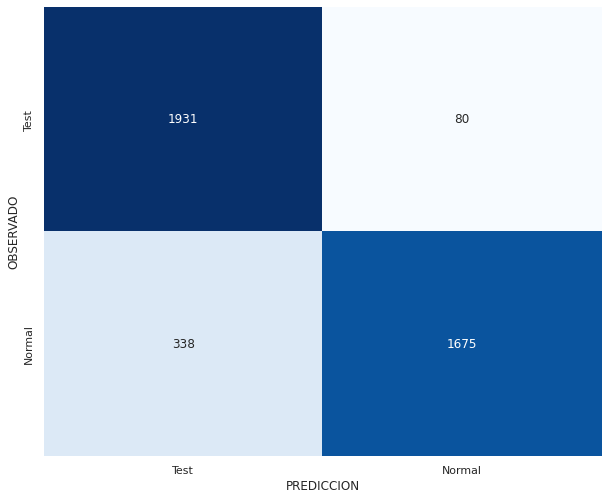

In [116]:
matrix=confusion_matrix(target_test, target_predict)
matrix
class_names=['Test','Normal']
# create dataframe
dataframe=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues",fmt='g')
plt.xlabel("PREDICCION")
plt.ylabel("OBSERVADO")

plt.show()

Como se observa, se ha generado la tabla de clasificación, en donde podemos ver el búen comporatmiento de las clasificación. Para resaltar: de 4 024 muestras que se pasaron al modelo, se lograron detectar correctamente 3.606, es decir el 90%

In [117]:
# imprimanos las metrica en general del modelo para todas las variedades
print(classification_report(target_test, target_predict, target_names=class_names))

              precision    recall  f1-score   support

        Test       0.85      0.96      0.90      2011
      Normal       0.95      0.83      0.89      2013

    accuracy                           0.90      4024
   macro avg       0.90      0.90      0.90      4024
weighted avg       0.90      0.90      0.90      4024



En la anterior tabla se muestran algunas d elas metricas de clasificación

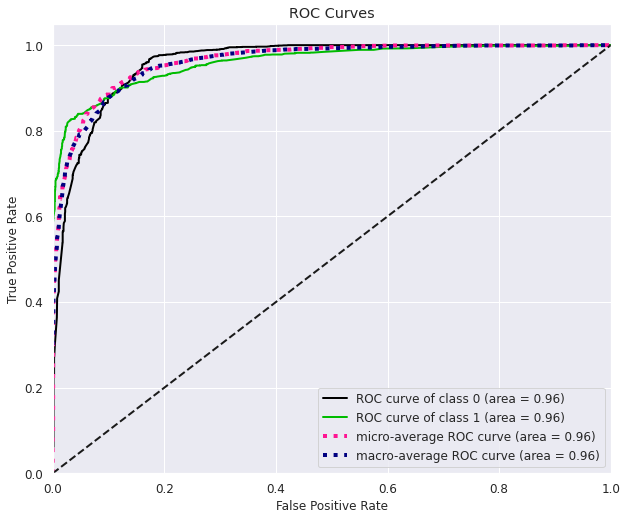

In [118]:
# visualizacion de la curva ROC
skplt.metrics.plot_roc(target_test, target_predict_proba)
plt.show()

La curva ROC tambíen muestra un buen coportamiento, por lo que podemos concluir que un modelo supervisado podría detectar peticiones anormales como lo fueron las tipo Test.

### Entrenamiento con Random Forest con busqueda de hiperparametros

Estableciendo los hiperparametros:

In [119]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
#max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]
# seleccion de gini o entropia
criterion=['gini', 'entropy']


# Create the random grid
hyperparameters_tuning = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':criterion}

print(hyperparameters_tuning)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [20, 40, 60, 80, 100], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


Entrenando el modelo:

In [120]:
# Creación de intancia de RandomForestClassifier
modeloRF = RandomForestClassifier()

# Busqueda de hiperparametros 
random_search_RF= RandomizedSearchCV(estimator=modeloRF,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=5, 
                                   verbose=1)

random_search_RF.fit(feature_train, target_train)
print("Mejores hiperparametros:",random_search_RF.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparametros: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'criterion': 'entropy', 'bootstrap': True}


In [121]:
predict_RF=random_search_RF.predict(feature_test)
predict_proba_RF=random_search_RF.predict_proba(feature_test)

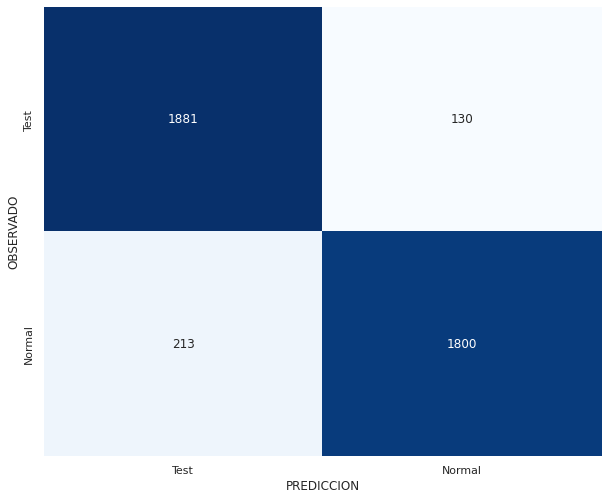

In [122]:
matrix=confusion_matrix(target_test, predict_RF)
matrix

# create dataframe
dataframe=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues",fmt='g')
plt.xlabel("PREDICCION")
plt.ylabel("OBSERVADO")
plt.show()

Como se observa en la tabla de clasificación y en la tabla, la clasificación general fue de 91%, mejoró un 1% con respecto a regresión logistica.

In [123]:
print(classification_report(target_test, predict_RF, target_names=class_names))

              precision    recall  f1-score   support

        Test       0.90      0.94      0.92      2011
      Normal       0.93      0.89      0.91      2013

    accuracy                           0.91      4024
   macro avg       0.92      0.91      0.91      4024
weighted avg       0.92      0.91      0.91      4024



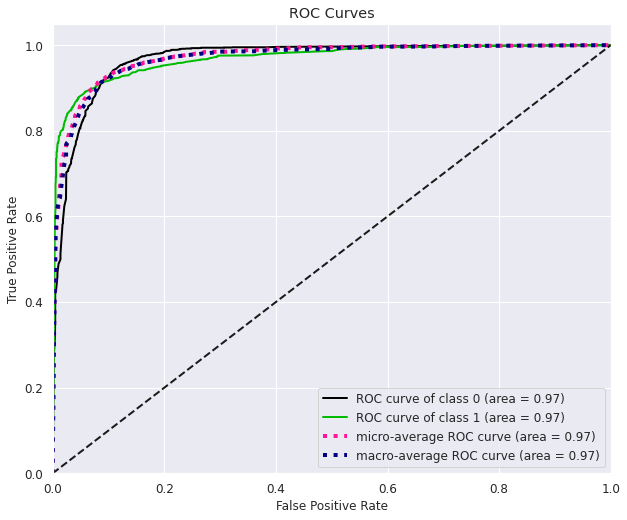

In [124]:
skplt.metrics.plot_roc(target_test, predict_proba_RF)
plt.show()

De igual manera se observa un buen comportamiento en la curva ROC

## Conclusiones


* Es posible realizar la detección de anomalias a nivel de usuario aun sin tener la etiqueta o label del evento, gracias al aprendizaje no supervisado utilizando OneClassSVM.

* Es posible realizar la detección de anomalías por eventos de manera similar a la detección por usuario, pero haciendo uso de más variables categoricas a través de dummies.

* A futuro y con mas datos con la etiqueta es posible identificar si el evento o log es o no malicioso. Con estos es posible formular un problema de aprendizado supervisado trabajando con NLP con el campo "Content" y con modelos tradicionale o BERT

* Se identificaron peticiones maliciosas de acuerdo al analisis de la variable Content sin embargo estas son muy pocas para poder entrenar un modelo que permita su identificación.

* Es posible construir el label para entrenar un modelos supervisado con modelo tradicionales o con BERT identiicando contenido maliciosos en la columnas Content pero con muchos mas datos.

* Se realizó el ejercicio de realizar entrenamiento con aprendizaje supervisado con la variable Test, obteniendo muy buenos resultados. 

## Comentarios


*	Se pudiese mejora el analisis si se capturan otras variables como el origen de la dirección IP, la medición de cantidad de tráfico por usuario y por supuesto la marcación de si el evento es o no malicioso.

* Seria un ventaja contar con el label ya que que permite entrenar modelos supervisados e inclusive trabajar con procesamiento del lenguaje natural sobre la variable “Content”

* Contar con más datos relacionado siempre es lo deseado, en el contexto de un sitio web sería importante contar con la ubicación geográfica de la IP, el trafico generado por el usuario al sitio web, las peticiones que realizó el usuario, cantidad de login, cantidad de peticiones en determinado tiempo, etc.
Es posible identificar peticiones maliciosas tipo XSS, inyección SQL, carga de archivos maliciosos y los demás especificados en el OWASP top 10 sobre campos en los cuales los usuarios envían comentarios, editan comentarios, cargan archivos o realizan algún post.
Si tuviésemos mas datos categorizados como maliciosos podríamos entrenar un modelo que nos permitirá identificar este tipo de eventos.
Es importante resaltar que a estas peticiones solo tendríamos acceso si esta viaja en texto plano sobre HTTP como es el caso del ejercicio. Muchos de los sitios en la actualidad trabajan sobre HTTPS.
